<a href="https://colab.research.google.com/github/E-Fung/Classification_PCD/blob/main/Copy_of_PCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INITIALIZE LIBRARIES AND FINAL FILE NAMES**

In [3]:
#########################################################################################################################################################################
#   Initialize libraries and such
#########################################################################################################################################################################

%tensorflow_version 2.x  # this line is not required unless you are in a notebook
from __future__ import absolute_import, division, print_function, unicode_literals
from mpl_toolkits.mplot3d import Axes3D
from google.colab import files
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import os
import math

# Print versions
!python --versions
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)
print('Keras ' + tf.keras.__version__)

tflite_model_name = 'PCD_Model'
c_model_name = 'PCD_Model'

#This is for gathering the metrics (accuracy % loss) for another set of values
class AdditionalValidationSets(tf.keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [3, 4]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for metric, result in zip(self.model.metrics_names,results):
                valuename = validation_set_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)

#########################################################################################################################################################################

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
unknown option --versions
usage: python3 [option] ... [-c cmd | -m mod | file | -] [arg] ...
Try `python -h' for more information.
Numpy 1.19.5
TensorFlow 2.4.1
Keras 2.4.0


In [4]:
#Verify that the data is good
dd1 = 'data_n01'
dd2 = 'data_n02'
dd3 = 'data_n03'
dd4 = 'data_n04'
dd5 = 'data_n05'
imp_dd1 = pd.read_csv(dd1+'.csv')
imp_dd2 = pd.read_csv(dd2+'.csv')
imp_dd3 = pd.read_csv(dd3+'.csv')
imp_dd4 = pd.read_csv(dd4+'.csv')
imp_dd5 = pd.read_csv(dd5+'.csv')
plt.subplot(1,5,1)
imp_dd1.Class.hist()
plt.subplot(1,5,2)
imp_dd2.Class.hist()
plt.subplot(1,5,3)
imp_dd3.Class.hist()
plt.subplot(1,5,4)
imp_dd4.Class.hist()
plt.subplot(1,5,5)
imp_dd5.Class.hist()

FileNotFoundError: ignored

# **UPLOADING**

In [9]:
#########################################################################################################################################################################
#   Uploading Files
#########################################################################################################################################################################

file_name = 'data_n05' #Change this to the name of the csv file you are uploading
uploaded = files.upload()
pd.read_csv(io.StringIO(uploaded[file_name+'.csv'].decode('utf-8')))

#########################################################################################################################################################################

Saving data_n05.csv to data_n05.csv


x1     y1     z1      x2     y2  ...     z3     x4     y4     z4  Class
0     -54.43  -9.85 -25.84 -151.32  15.80  ...  12.42 -72.32 -30.98   6.95      0
1     -53.72 -10.31 -25.93 -150.96  16.49  ...  12.71 -72.28 -30.92   7.66      0
2     -53.24 -10.59 -25.99 -150.69  16.83  ...  13.33 -72.37 -31.02   8.77      0
3     -52.69 -10.92 -26.21 -150.40  17.08  ...  13.80 -72.45 -31.20   9.56      0
4     -52.04 -11.24 -26.75 -149.88  17.49  ...  14.27 -72.64 -31.29  10.56      0
...      ...    ...    ...     ...    ...  ...    ...    ...    ...    ...    ...
12851  82.23 -22.88 -18.01  -17.48  26.27  ...  24.17 -28.80 -31.79   7.93      4
12852  82.66 -23.01 -17.63  -17.57  26.28  ...  23.64 -28.21 -31.39   7.75      4
12853  83.28 -23.26 -17.06  -17.57  26.10  ...  23.38 -27.41 -31.41   7.66      4
12854  83.31 -23.03 -16.90  -17.54  25.92  ...  23.20 -26.54 -31.76   7.52      4
12855  83.21 -22.70 -16.81  -17.46  26.02  ...  23.27 -25.76 -32.22   7.32      4

[12856 rows x 13 columns]

# **PROCESSING**

In [10]:
#########################################################################################################################################################################
#   This block of code is for processing the data, made into a function to implement n-fold cross validation
#########################################################################################################################################################################

def get_data(i):

  #Change these
  train_row_increments = 5
  test_row_increments = 5

  data_arr = ['data_n01','data_n02','data_n03','data_n04','data_n05']
  test_data = data_arr[i]
  data_arr.remove(data_arr[i])

  train_data_01 = data_arr[0]
  train_data_02 = data_arr[1]
  train_data_03 = data_arr[2]
  train_data_04 = data_arr[3]

  #Initialize dataframes for storing the data and combine them to increase effectiveness of model
  train_data1 = pd.read_csv(train_data_01+'.csv')
  train_data2 = pd.read_csv(train_data_02+'.csv')
  train_data3 = pd.read_csv(train_data_03+'.csv')
  train_data4 = pd.read_csv(train_data_04+'.csv')
  train_data_combined = pd.concat([train_data1,train_data2,train_data3,train_data4],ignore_index=True)

  #Process the data::
  train_data_sampled = train_data_combined[1::train_row_increments]#sample every 'train_row_increments' row (IMUs give data very frequently so the data is very similar)
  data_shuffled = train_data_sampled.sample(frac=1).reset_index(drop=True)#shuffle it
  d0 = data_shuffled.loc[data_shuffled['Class'] == 0]#how much data for each posture
  d1 = data_shuffled.loc[data_shuffled['Class'] == 1]
  d2 = data_shuffled.loc[data_shuffled['Class'] == 2]
  d3 = data_shuffled.loc[data_shuffled['Class'] == 3]
  d4 = data_shuffled.loc[data_shuffled['Class'] == 4]
  min_class = min(len(d0),len(d1),len(d2),len(d3),len(d4))
  d0_split = d0.sample(frac=(min_class/len(d0)),random_state=1) #get the same amount for each posture
  d1_split = d1.sample(frac=(min_class/len(d1)),random_state=1) 
  d2_split = d2.sample(frac=(min_class/len(d2)),random_state=1) 
  d3_split = d3.sample(frac=(min_class/len(d3)),random_state=1) 
  d4_split = d4.sample(frac=(min_class/len(d4)),random_state=1) 
  data_final_combine = pd.concat([d0_split,d1_split,d2_split,d3_split,d4_split],ignore_index=True)#combine
  data_processed = data_final_combine.sample(frac=1).reset_index(drop=True)#shuffle again
  posture_processed = data_processed.pop('Class')
  data_processed = data_processed/180

  global x_val,x_train,y_val,y_train,test,test_pop

  #Split the data into 3 sets:: Training, Validation(used to check against overfitting, you dont want training accuracy to be over validation) 
  val_ratio = 0.3    # Percentage of samples that should be held for validation set
  length_data_processed = data_processed.shape[0]
  val_split = int(val_ratio * length_data_processed)
  x_val, x_train = np.split(data_processed, [val_split])
  y_val, y_train = np.split(posture_processed, [val_split])
  assert(x_train.size + x_val.size) == data_processed.size

  #Process the data for the testing data (This will be data from a new user that has never had their data in the training set)
  test = pd.read_csv(test_data+'.csv')
  test = test [1::test_row_increments]
  test = test.sample(frac=1).reset_index(drop=True)
  test_pop = test.pop('Class')
  test = test / 180

#########################################################################################################################################################################

# **TRAINING**

Model: "sequential_202"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_202 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 110)               1430      
_________________________________________________________________
dropout_202 (Dropout)        (None, 110)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 555       
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________
0 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.2037 - accuracy: 0.5244 - val_loss: 1.6225 - val_accuracy: 0.4098

Epoch 00001: val_accuracy improved from -inf to 0.40976, saving model to training_0/cp.

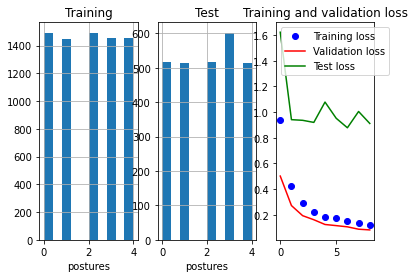

84/84 - 0s - loss: 0.9113 - accuracy: 0.7268

Test accuracy: 0.7268292903900146


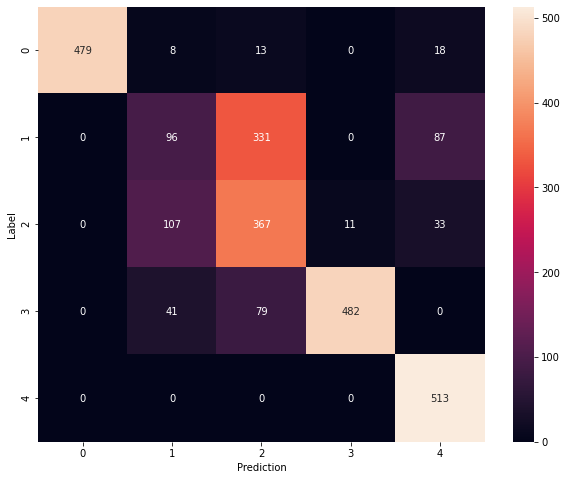

Model: "sequential_203"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_203 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 110)               1430      
_________________________________________________________________
dropout_203 (Dropout)        (None, 110)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 555       
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________
1 out of 100 runs
Epoch 1/30
225/225 [==============================] - 1s 3ms/step - loss: 1.2148 - accuracy: 0.5122 - val_loss: 0.8442 - val_accuracy: 0.6225

Epoch 00001: val_accuracy improved from -inf to 0.62251, saving model to training_1/cp.

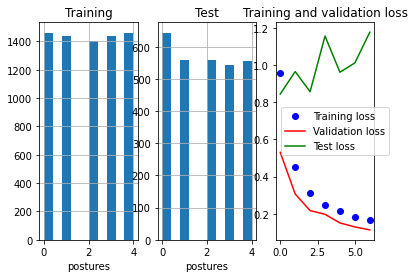

90/90 - 0s - loss: 1.1761 - accuracy: 0.7026

Test accuracy: 0.702551543712616


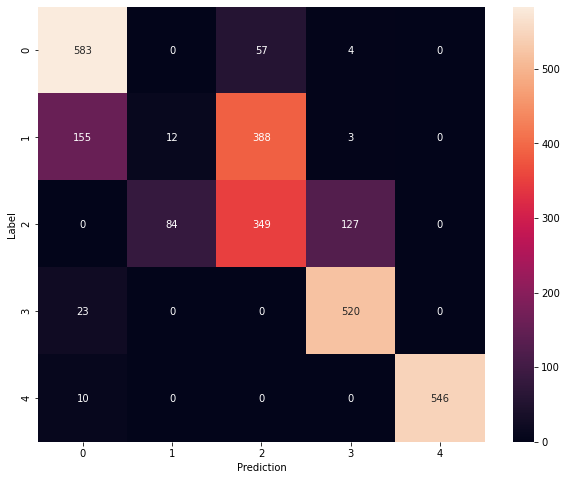

Model: "sequential_204"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_204 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 110)               1430      
_________________________________________________________________
dropout_204 (Dropout)        (None, 110)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 555       
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________
2 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.2310 - accuracy: 0.5111 - val_loss: 1.0363 - val_accuracy: 0.6139

Epoch 00001: val_accuracy improved from -inf to 0.61389, saving model to training_2/cp.

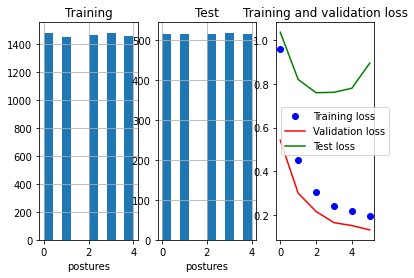

81/81 - 0s - loss: 0.8951 - accuracy: 0.7431

Test accuracy: 0.7431121468544006


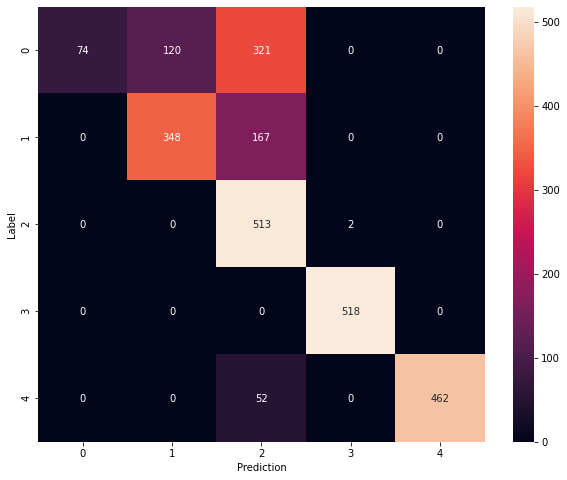

Model: "sequential_205"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_205 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 110)               1430      
_________________________________________________________________
dropout_205 (Dropout)        (None, 110)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 555       
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________
3 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1806 - accuracy: 0.5127 - val_loss: 1.4067 - val_accuracy: 0.5085

Epoch 00001: val_accuracy improved from -inf to 0.50853, saving model to training_3/cp.

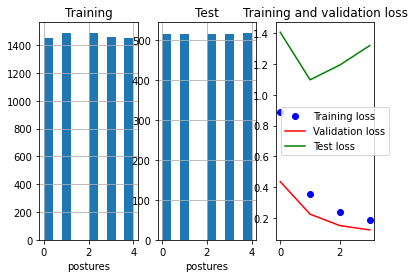

81/81 - 0s - loss: 1.3202 - accuracy: 0.5446

Test accuracy: 0.5446082353591919


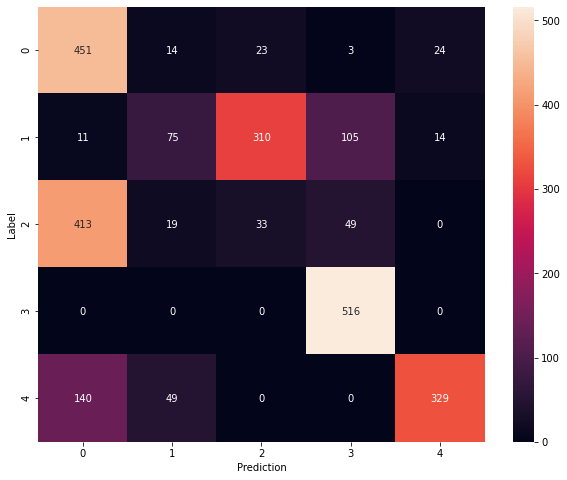

Model: "sequential_206"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_206 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 110)               1430      
_________________________________________________________________
dropout_206 (Dropout)        (None, 110)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 555       
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________
4 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1841 - accuracy: 0.5325 - val_loss: 1.1904 - val_accuracy: 0.5955

Epoch 00001: val_accuracy improved from -inf to 0.59549, saving model to training_4/cp.

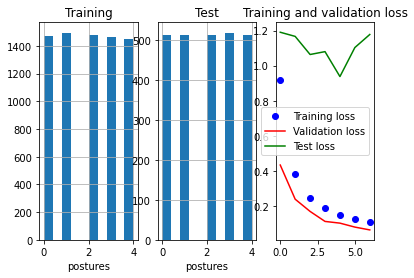

81/81 - 0s - loss: 1.1776 - accuracy: 0.6834

Test accuracy: 0.6833916902542114


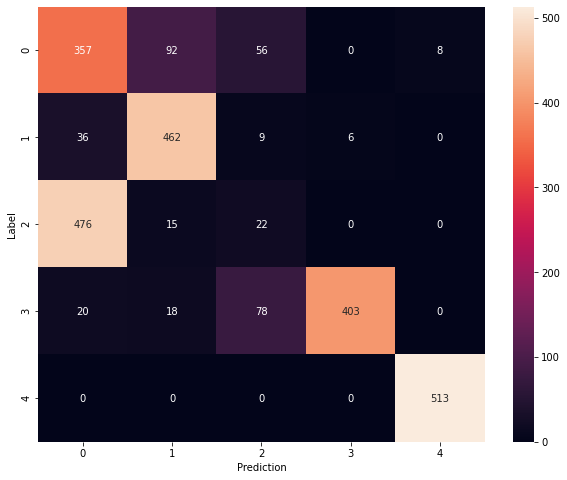

Model: "sequential_207"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_207 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 110)               1430      
_________________________________________________________________
dropout_207 (Dropout)        (None, 110)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 555       
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________
5 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.2106 - accuracy: 0.5174 - val_loss: 1.4450 - val_accuracy: 0.4251

Epoch 00001: val_accuracy improved from -inf to 0.42514, saving model to training_5/cp.

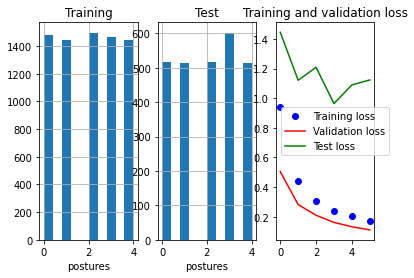

84/84 - 0s - loss: 1.1230 - accuracy: 0.6645

Test accuracy: 0.6645403504371643


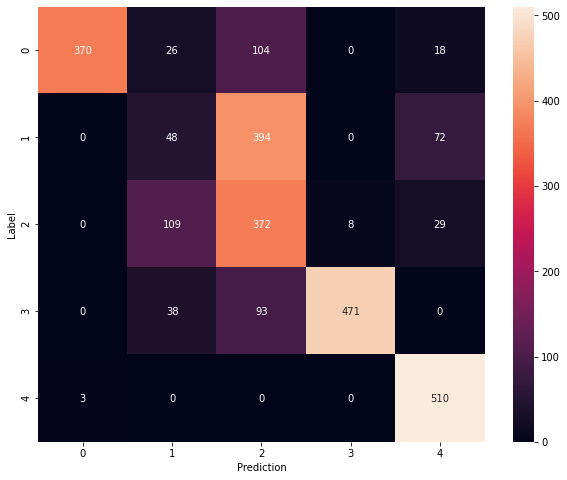

Model: "sequential_208"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_208 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 110)               1430      
_________________________________________________________________
dropout_208 (Dropout)        (None, 110)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 555       
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________
6 out of 100 runs
Epoch 1/30
225/225 [==============================] - 1s 3ms/step - loss: 1.2345 - accuracy: 0.5029 - val_loss: 1.0103 - val_accuracy: 0.6347

Epoch 00001: val_accuracy improved from -inf to 0.63474, saving model to training_6/cp.

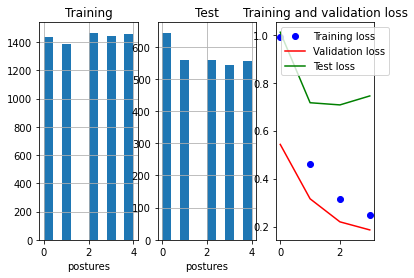

90/90 - 0s - loss: 0.7447 - accuracy: 0.7214

Test accuracy: 0.7214260697364807


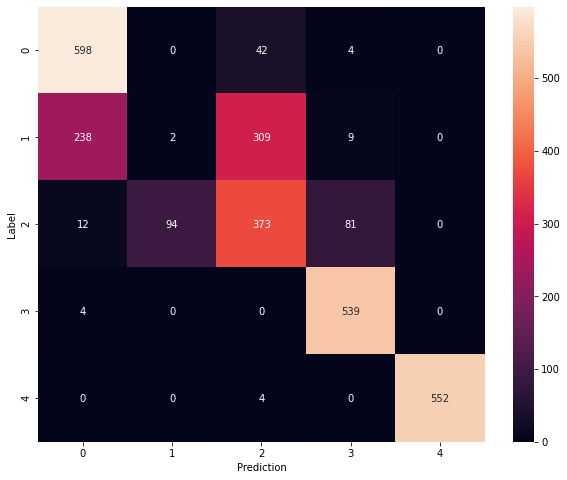

Model: "sequential_209"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_209 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 110)               1430      
_________________________________________________________________
dropout_209 (Dropout)        (None, 110)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 555       
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________
7 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.2130 - accuracy: 0.5211 - val_loss: 0.8786 - val_accuracy: 0.6251

Epoch 00001: val_accuracy improved from -inf to 0.62515, saving model to training_7/cp.

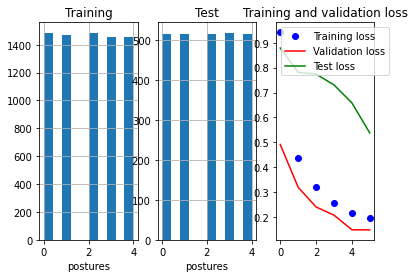

81/81 - 0s - loss: 0.5377 - accuracy: 0.7687

Test accuracy: 0.7687233090400696


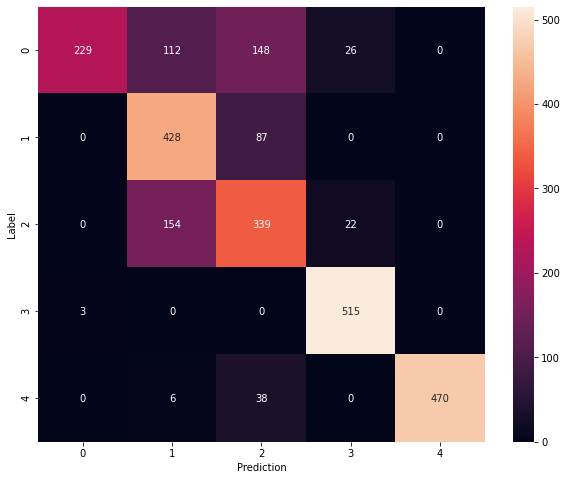

Model: "sequential_210"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_210 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 110)               1430      
_________________________________________________________________
dropout_210 (Dropout)        (None, 110)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 555       
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________
8 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1570 - accuracy: 0.5380 - val_loss: 1.3674 - val_accuracy: 0.5508

Epoch 00001: val_accuracy improved from -inf to 0.55081, saving model to training_8/cp.

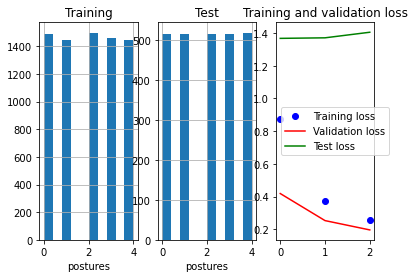

81/81 - 0s - loss: 1.4048 - accuracy: 0.5326

Test accuracy: 0.5325834155082703


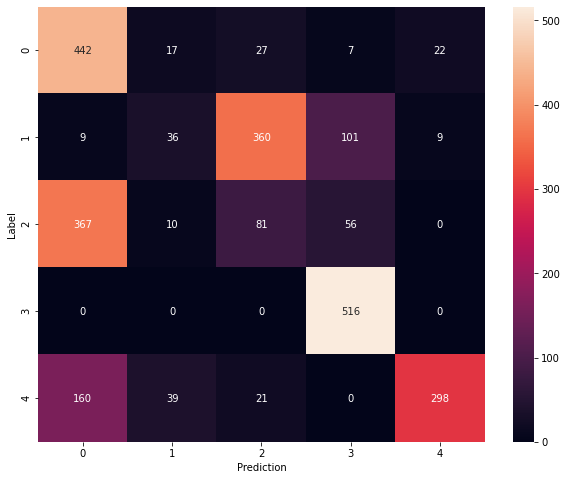

Model: "sequential_211"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_211 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 110)               1430      
_________________________________________________________________
dropout_211 (Dropout)        (None, 110)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 555       
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________
9 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1820 - accuracy: 0.5212 - val_loss: 1.2437 - val_accuracy: 0.5329

Epoch 00001: val_accuracy improved from -inf to 0.53287, saving model to training_9/cp.

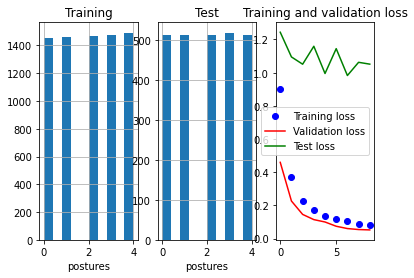

81/81 - 0s - loss: 1.0514 - accuracy: 0.7133

Test accuracy: 0.7133411169052124


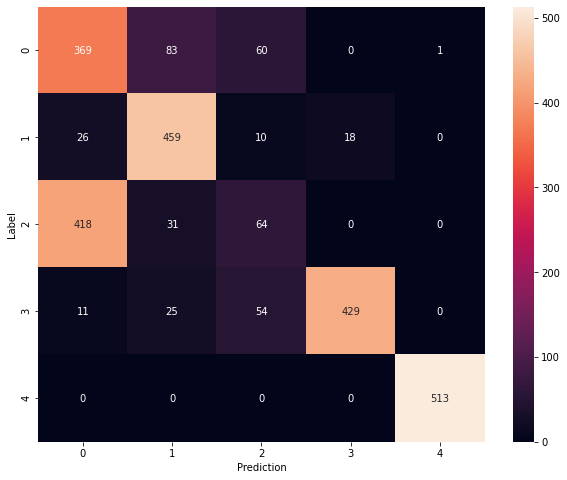

Model: "sequential_212"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_212 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 115)               1495      
_________________________________________________________________
dropout_212 (Dropout)        (None, 115)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 580       
Total params: 2,075
Trainable params: 2,075
Non-trainable params: 0
_________________________________________________________________
10 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1897 - accuracy: 0.5216 - val_loss: 1.2756 - val_accuracy: 0.4826

Epoch 00001: val_accuracy improved from -inf to 0.48255, saving model to training_10/c

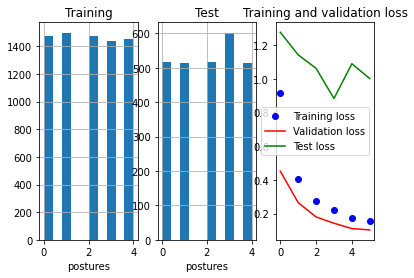

84/84 - 0s - loss: 1.0006 - accuracy: 0.7535

Test accuracy: 0.7534708976745605


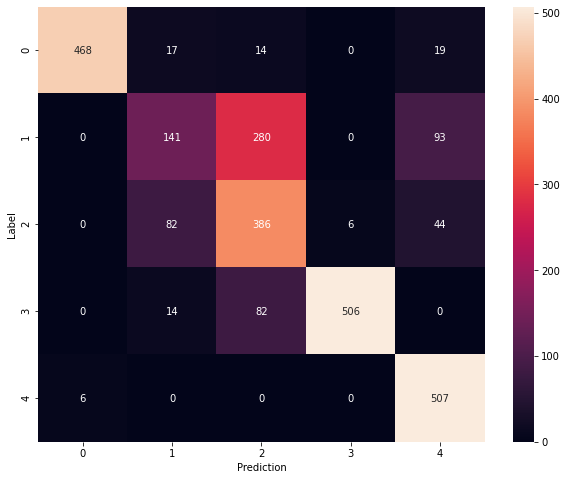

Model: "sequential_213"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_213 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 115)               1495      
_________________________________________________________________
dropout_213 (Dropout)        (None, 115)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 580       
Total params: 2,075
Trainable params: 2,075
Non-trainable params: 0
_________________________________________________________________
11 out of 100 runs
Epoch 1/30
225/225 [==============================] - 1s 3ms/step - loss: 1.2024 - accuracy: 0.5163 - val_loss: 0.9351 - val_accuracy: 0.5477

Epoch 00001: val_accuracy improved from -inf to 0.54771, saving model to training_11/c

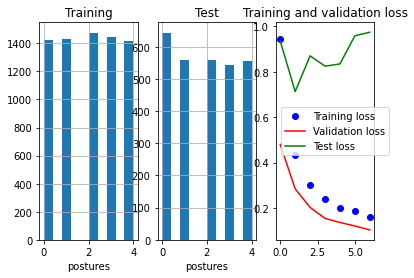

90/90 - 0s - loss: 0.9738 - accuracy: 0.7120

Test accuracy: 0.7119888067245483


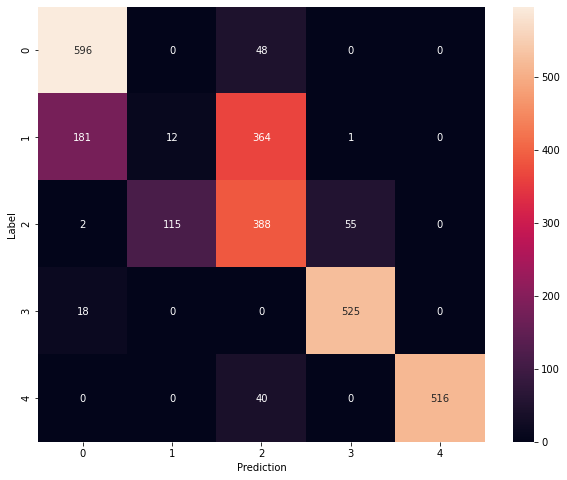

Model: "sequential_214"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_214 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 115)               1495      
_________________________________________________________________
dropout_214 (Dropout)        (None, 115)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 580       
Total params: 2,075
Trainable params: 2,075
Non-trainable params: 0
_________________________________________________________________
12 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.2033 - accuracy: 0.5213 - val_loss: 0.8707 - val_accuracy: 0.6865

Epoch 00001: val_accuracy improved from -inf to 0.68646, saving model to training_12/c

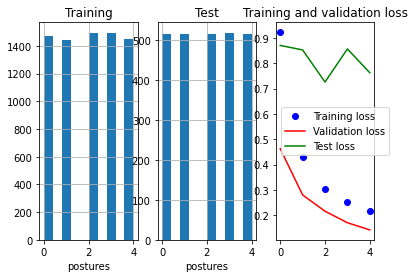

81/81 - 0s - loss: 0.7629 - accuracy: 0.6558

Test accuracy: 0.6558012962341309


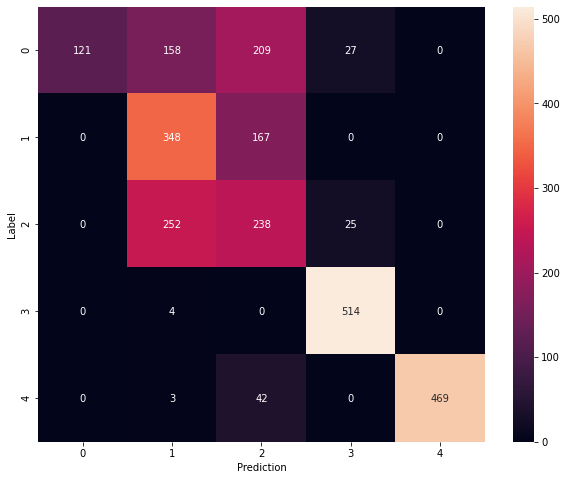

Model: "sequential_215"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_215 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 115)               1495      
_________________________________________________________________
dropout_215 (Dropout)        (None, 115)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 580       
Total params: 2,075
Trainable params: 2,075
Non-trainable params: 0
_________________________________________________________________
13 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1721 - accuracy: 0.5249 - val_loss: 1.3647 - val_accuracy: 0.5206

Epoch 00001: val_accuracy improved from -inf to 0.52056, saving model to training_13/c

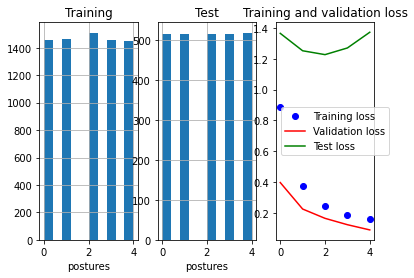

81/81 - 0s - loss: 1.3719 - accuracy: 0.5272

Test accuracy: 0.5271528363227844


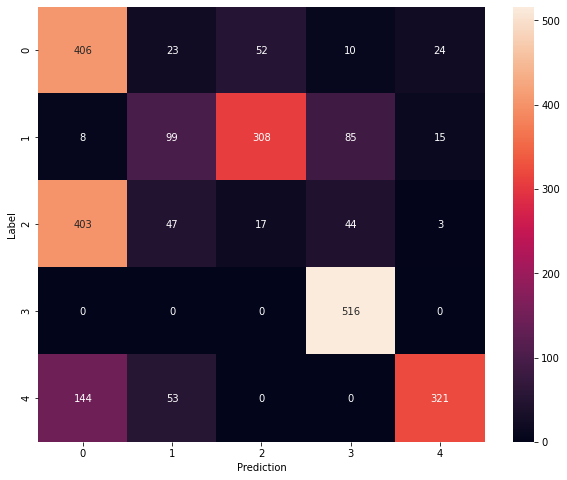

Model: "sequential_216"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_216 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 115)               1495      
_________________________________________________________________
dropout_216 (Dropout)        (None, 115)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 580       
Total params: 2,075
Trainable params: 2,075
Non-trainable params: 0
_________________________________________________________________
14 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1757 - accuracy: 0.5335 - val_loss: 1.0719 - val_accuracy: 0.6262

Epoch 00001: val_accuracy improved from -inf to 0.62622, saving model to training_14/c

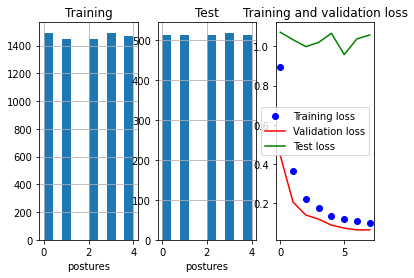

81/81 - 0s - loss: 1.0581 - accuracy: 0.7285

Test accuracy: 0.728510320186615


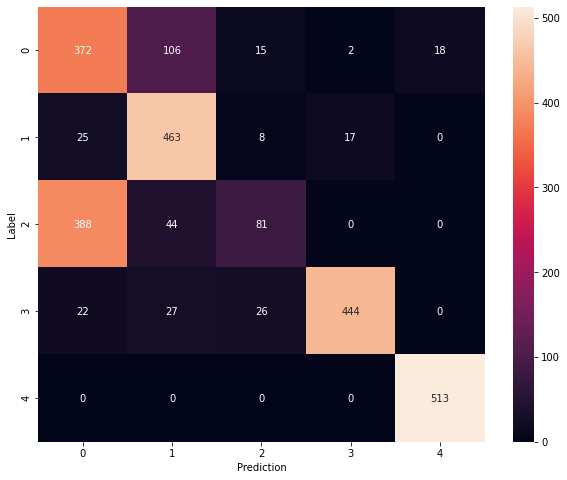

Model: "sequential_217"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_217 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 115)               1495      
_________________________________________________________________
dropout_217 (Dropout)        (None, 115)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 580       
Total params: 2,075
Trainable params: 2,075
Non-trainable params: 0
_________________________________________________________________
15 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1759 - accuracy: 0.5301 - val_loss: 1.5097 - val_accuracy: 0.4507

Epoch 00001: val_accuracy improved from -inf to 0.45066, saving model to training_15/c

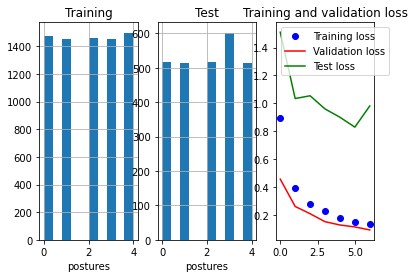

84/84 - 0s - loss: 0.9813 - accuracy: 0.7126

Test accuracy: 0.7125703692436218


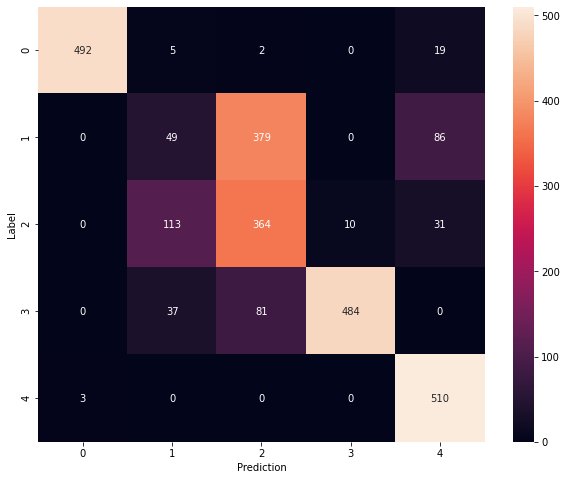

Model: "sequential_218"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_218 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 115)               1495      
_________________________________________________________________
dropout_218 (Dropout)        (None, 115)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 580       
Total params: 2,075
Trainable params: 2,075
Non-trainable params: 0
_________________________________________________________________
16 out of 100 runs
Epoch 1/30
225/225 [==============================] - 1s 3ms/step - loss: 1.2302 - accuracy: 0.4797 - val_loss: 0.8951 - val_accuracy: 0.6211

Epoch 00001: val_accuracy improved from -inf to 0.62111, saving model to training_16/c

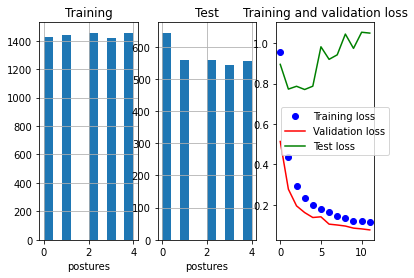

90/90 - 0s - loss: 1.0497 - accuracy: 0.7480

Test accuracy: 0.7479901909828186


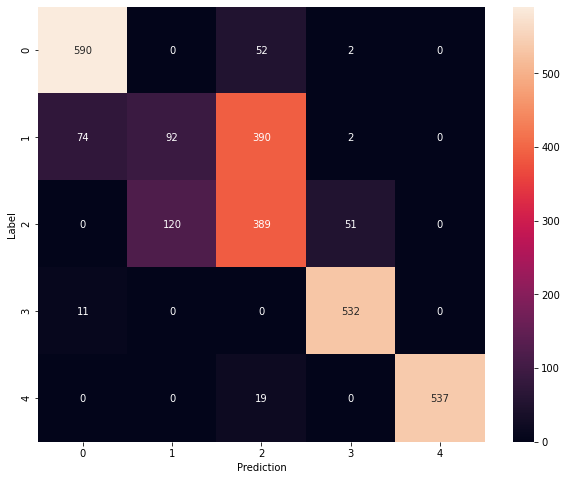

Model: "sequential_219"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_219 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 115)               1495      
_________________________________________________________________
dropout_219 (Dropout)        (None, 115)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 580       
Total params: 2,075
Trainable params: 2,075
Non-trainable params: 0
_________________________________________________________________
17 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.2437 - accuracy: 0.4992 - val_loss: 0.9317 - val_accuracy: 0.7225

Epoch 00001: val_accuracy improved from -inf to 0.72255, saving model to training_17/c

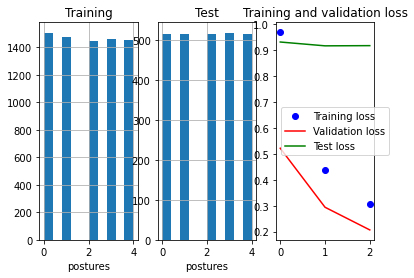

81/81 - 0s - loss: 0.9177 - accuracy: 0.6868

Test accuracy: 0.6868451833724976


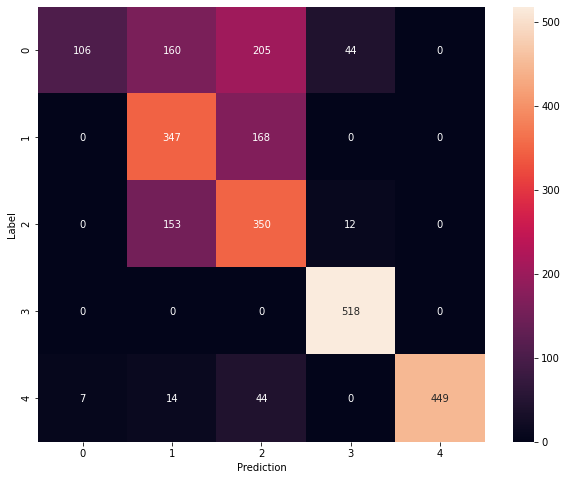

Model: "sequential_220"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_220 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 115)               1495      
_________________________________________________________________
dropout_220 (Dropout)        (None, 115)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 580       
Total params: 2,075
Trainable params: 2,075
Non-trainable params: 0
_________________________________________________________________
18 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1681 - accuracy: 0.5326 - val_loss: 1.3642 - val_accuracy: 0.5415

Epoch 00001: val_accuracy improved from -inf to 0.54151, saving model to training_18/c

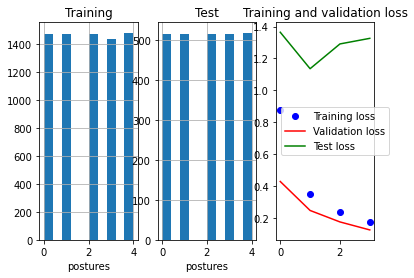

81/81 - 0s - loss: 1.3260 - accuracy: 0.5539

Test accuracy: 0.5539177656173706


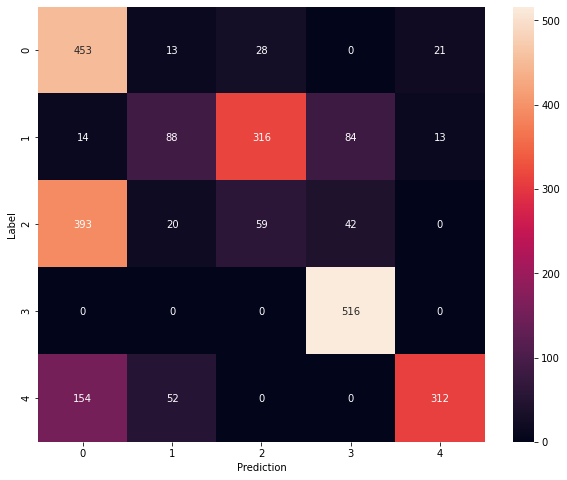

Model: "sequential_221"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_221 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 115)               1495      
_________________________________________________________________
dropout_221 (Dropout)        (None, 115)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 580       
Total params: 2,075
Trainable params: 2,075
Non-trainable params: 0
_________________________________________________________________
19 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1697 - accuracy: 0.5346 - val_loss: 1.2265 - val_accuracy: 0.5702

Epoch 00001: val_accuracy improved from -inf to 0.57021, saving model to training_19/c

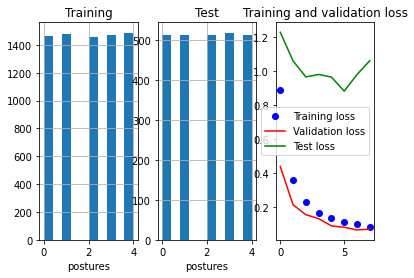

81/81 - 0s - loss: 1.0593 - accuracy: 0.6962

Test accuracy: 0.6962271332740784


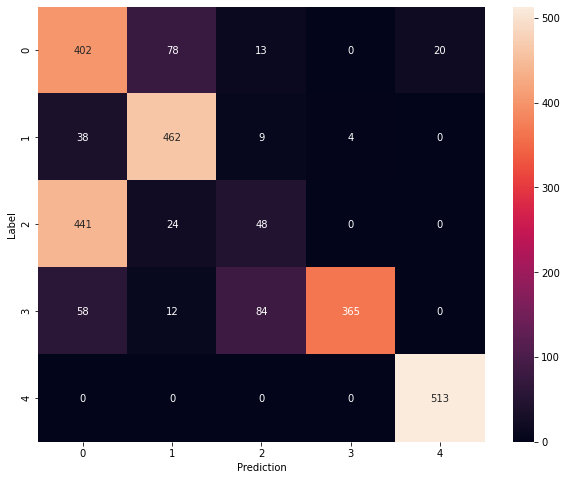

Model: "sequential_222"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_222 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 120)               1560      
_________________________________________________________________
dropout_222 (Dropout)        (None, 120)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 605       
Total params: 2,165
Trainable params: 2,165
Non-trainable params: 0
_________________________________________________________________
20 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1737 - accuracy: 0.5256 - val_loss: 1.3578 - val_accuracy: 0.4773

Epoch 00001: val_accuracy improved from -inf to 0.47730, saving model to training_20/c

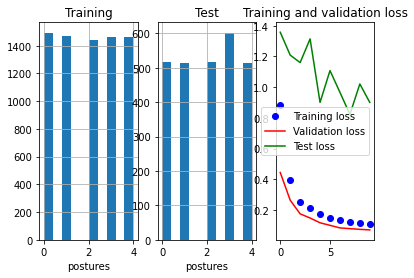

84/84 - 0s - loss: 0.9008 - accuracy: 0.7347

Test accuracy: 0.7347092032432556


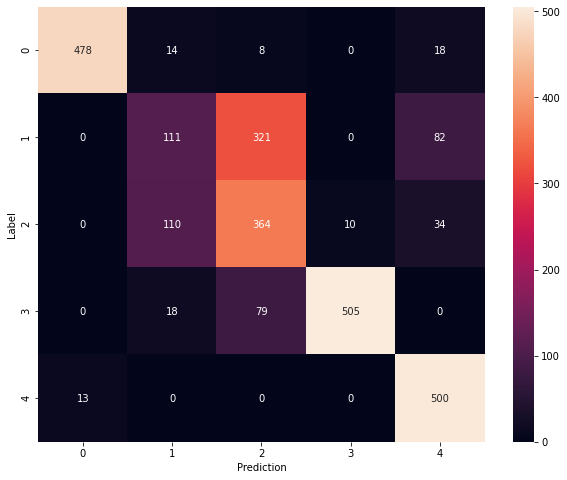

Model: "sequential_223"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_223 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 120)               1560      
_________________________________________________________________
dropout_223 (Dropout)        (None, 120)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 605       
Total params: 2,165
Trainable params: 2,165
Non-trainable params: 0
_________________________________________________________________
21 out of 100 runs
Epoch 1/30
225/225 [==============================] - 1s 4ms/step - loss: 1.2141 - accuracy: 0.5001 - val_loss: 0.8375 - val_accuracy: 0.6487

Epoch 00001: val_accuracy improved from -inf to 0.64872, saving model to training_21/c

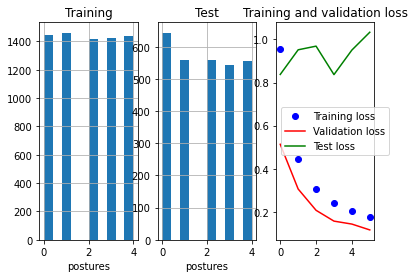

90/90 - 0s - loss: 1.0331 - accuracy: 0.7064

Test accuracy: 0.7063963413238525


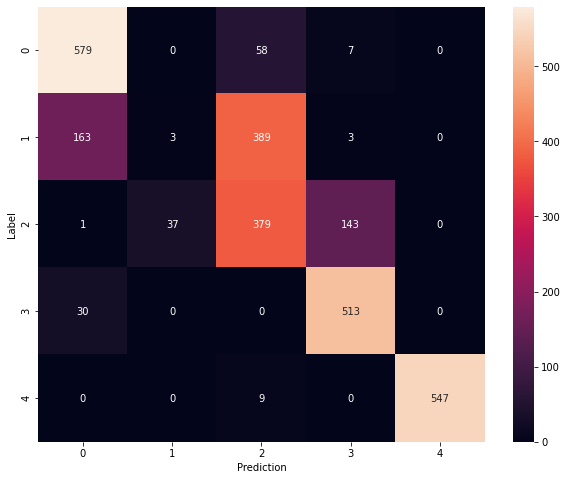

Model: "sequential_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_224 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 120)               1560      
_________________________________________________________________
dropout_224 (Dropout)        (None, 120)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 605       
Total params: 2,165
Trainable params: 2,165
Non-trainable params: 0
_________________________________________________________________
22 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1961 - accuracy: 0.5253 - val_loss: 0.8996 - val_accuracy: 0.6931

Epoch 00001: val_accuracy improved from -inf to 0.69305, saving model to training_22/c

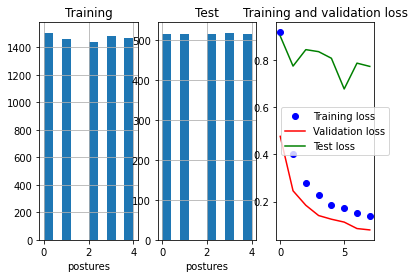

81/81 - 0s - loss: 0.7715 - accuracy: 0.7761

Test accuracy: 0.7760962247848511


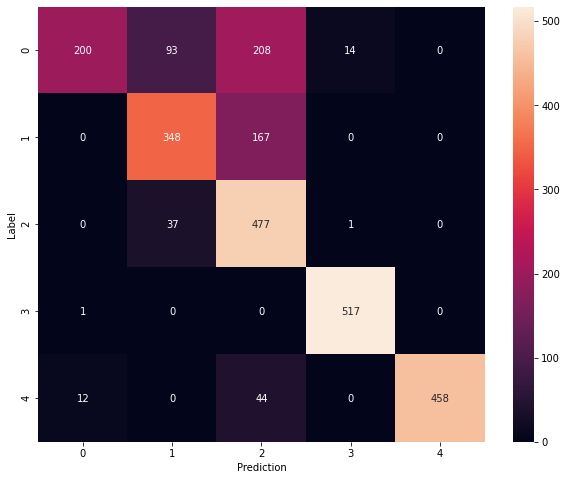

Model: "sequential_225"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_225 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 120)               1560      
_________________________________________________________________
dropout_225 (Dropout)        (None, 120)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 605       
Total params: 2,165
Trainable params: 2,165
Non-trainable params: 0
_________________________________________________________________
23 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1664 - accuracy: 0.5273 - val_loss: 1.4877 - val_accuracy: 0.5097

Epoch 00001: val_accuracy improved from -inf to 0.50970, saving model to training_23/c

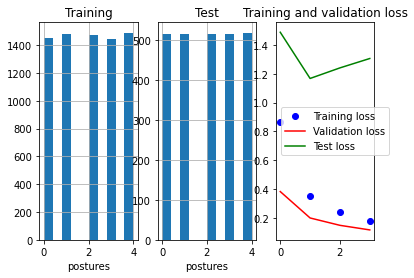

81/81 - 0s - loss: 1.3055 - accuracy: 0.5423

Test accuracy: 0.5422808527946472


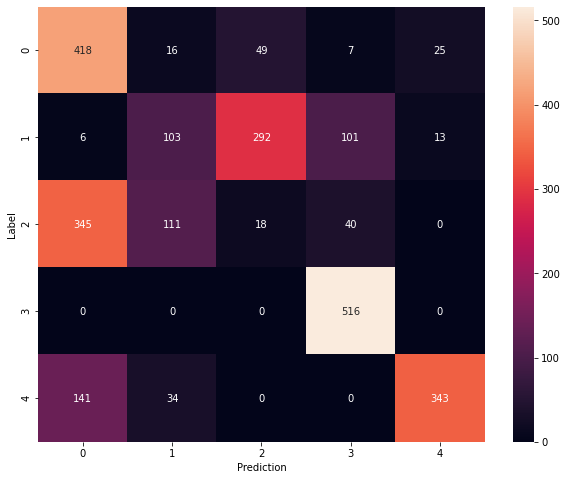

Model: "sequential_226"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_226 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 120)               1560      
_________________________________________________________________
dropout_226 (Dropout)        (None, 120)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 605       
Total params: 2,165
Trainable params: 2,165
Non-trainable params: 0
_________________________________________________________________
24 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1433 - accuracy: 0.5371 - val_loss: 1.1328 - val_accuracy: 0.5434

Epoch 00001: val_accuracy improved from -inf to 0.54337, saving model to training_24/c

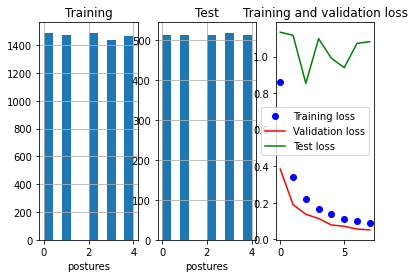

81/81 - 0s - loss: 1.0810 - accuracy: 0.7308

Test accuracy: 0.7308440208435059


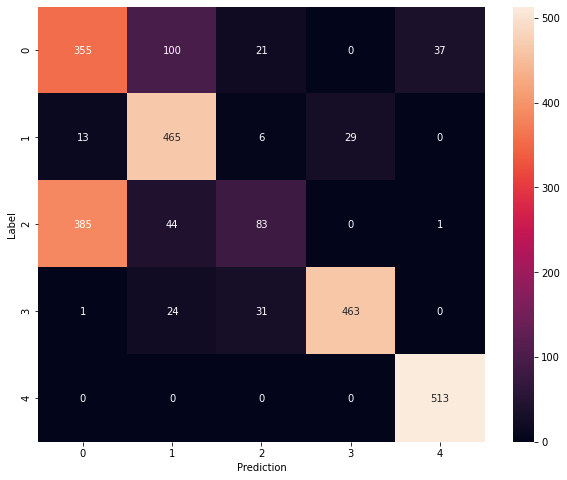

Model: "sequential_227"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_227 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 120)               1560      
_________________________________________________________________
dropout_227 (Dropout)        (None, 120)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 605       
Total params: 2,165
Trainable params: 2,165
Non-trainable params: 0
_________________________________________________________________
25 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1846 - accuracy: 0.5141 - val_loss: 1.3548 - val_accuracy: 0.4634

Epoch 00001: val_accuracy improved from -inf to 0.46341, saving model to training_25/c

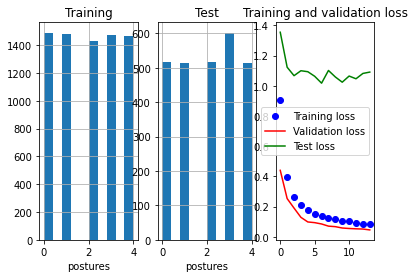

84/84 - 0s - loss: 1.0909 - accuracy: 0.7257

Test accuracy: 0.7257035374641418


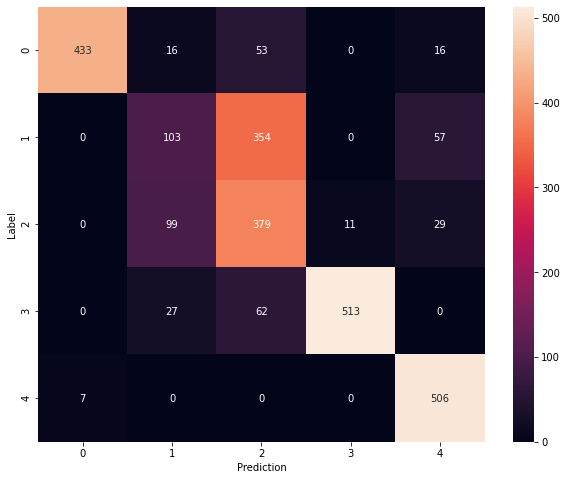

Model: "sequential_228"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_228 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 120)               1560      
_________________________________________________________________
dropout_228 (Dropout)        (None, 120)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 605       
Total params: 2,165
Trainable params: 2,165
Non-trainable params: 0
_________________________________________________________________
26 out of 100 runs
Epoch 1/30
225/225 [==============================] - 1s 4ms/step - loss: 1.2123 - accuracy: 0.4937 - val_loss: 0.9519 - val_accuracy: 0.6089

Epoch 00001: val_accuracy improved from -inf to 0.60888, saving model to training_26/c

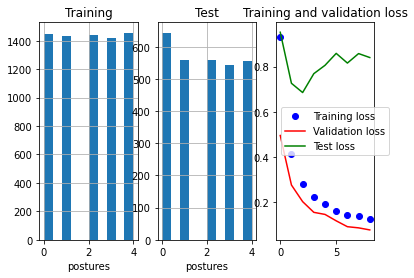

90/90 - 0s - loss: 0.8402 - accuracy: 0.7340

Test accuracy: 0.7340090870857239


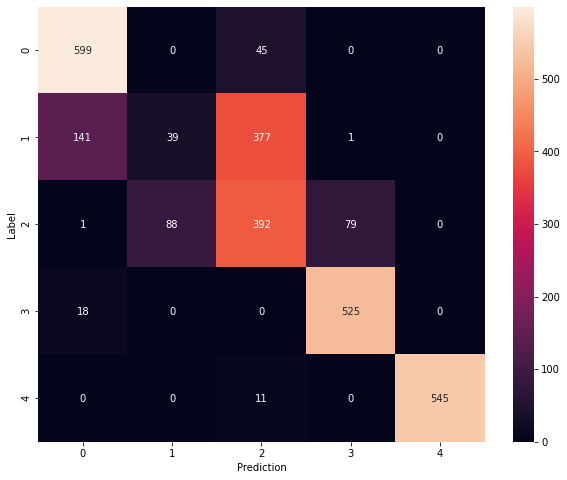

Model: "sequential_229"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_229 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 120)               1560      
_________________________________________________________________
dropout_229 (Dropout)        (None, 120)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 605       
Total params: 2,165
Trainable params: 2,165
Non-trainable params: 0
_________________________________________________________________
27 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.2016 - accuracy: 0.5221 - val_loss: 0.7715 - val_accuracy: 0.7532

Epoch 00001: val_accuracy improved from -inf to 0.75320, saving model to training_27/c

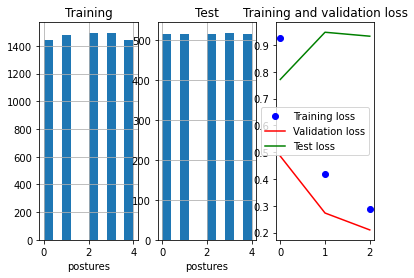

81/81 - 0s - loss: 0.9330 - accuracy: 0.7447

Test accuracy: 0.7446643114089966


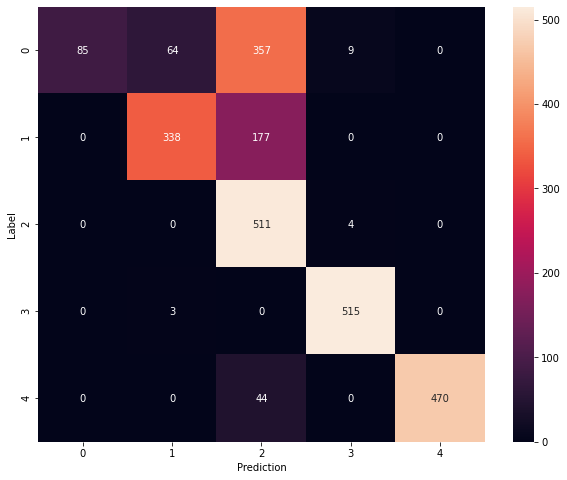

Model: "sequential_230"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_230 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 120)               1560      
_________________________________________________________________
dropout_230 (Dropout)        (None, 120)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 605       
Total params: 2,165
Trainable params: 2,165
Non-trainable params: 0
_________________________________________________________________
28 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1431 - accuracy: 0.5366 - val_loss: 1.2617 - val_accuracy: 0.5310

Epoch 00001: val_accuracy improved from -inf to 0.53103, saving model to training_28/c

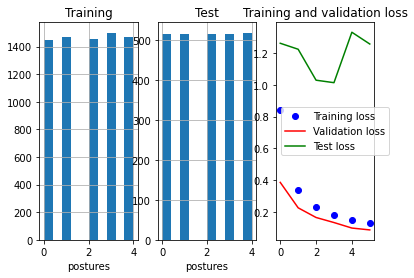

81/81 - 0s - loss: 1.2570 - accuracy: 0.5760

Test accuracy: 0.5760279297828674


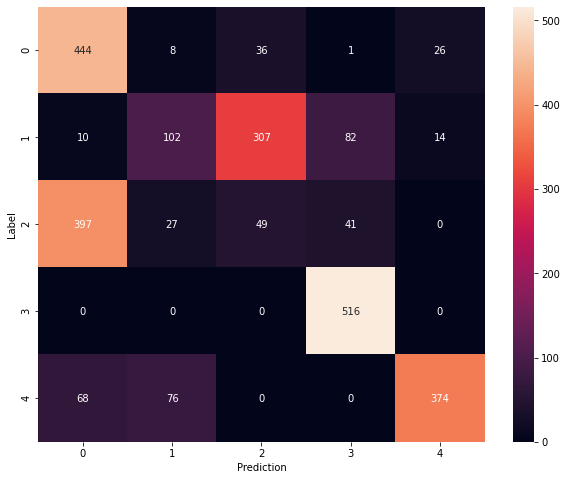

Model: "sequential_231"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_231 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 120)               1560      
_________________________________________________________________
dropout_231 (Dropout)        (None, 120)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 605       
Total params: 2,165
Trainable params: 2,165
Non-trainable params: 0
_________________________________________________________________
29 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1528 - accuracy: 0.5391 - val_loss: 1.2879 - val_accuracy: 0.5403

Epoch 00001: val_accuracy improved from -inf to 0.54026, saving model to training_29/c

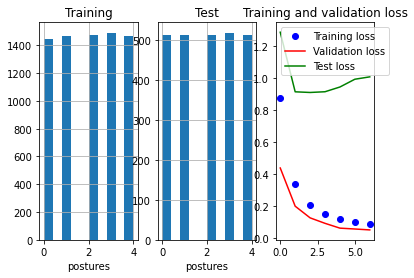

81/81 - 0s - loss: 1.0091 - accuracy: 0.7001

Test accuracy: 0.7001166939735413


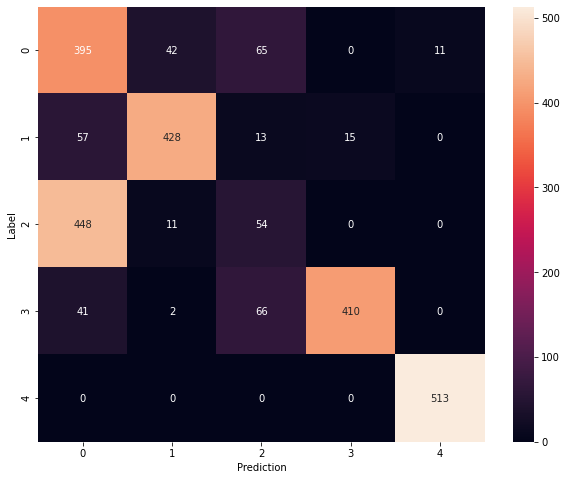

Model: "sequential_232"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_232 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 125)               1625      
_________________________________________________________________
dropout_232 (Dropout)        (None, 125)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 630       
Total params: 2,255
Trainable params: 2,255
Non-trainable params: 0
_________________________________________________________________
30 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1566 - accuracy: 0.5367 - val_loss: 1.1412 - val_accuracy: 0.5343

Epoch 00001: val_accuracy improved from -inf to 0.53433, saving model to training_30/c

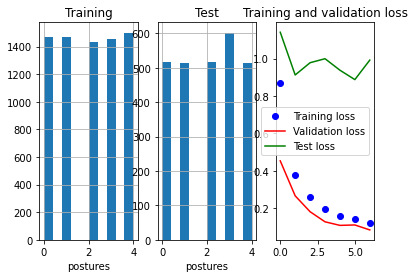

84/84 - 0s - loss: 0.9921 - accuracy: 0.6953

Test accuracy: 0.695309579372406


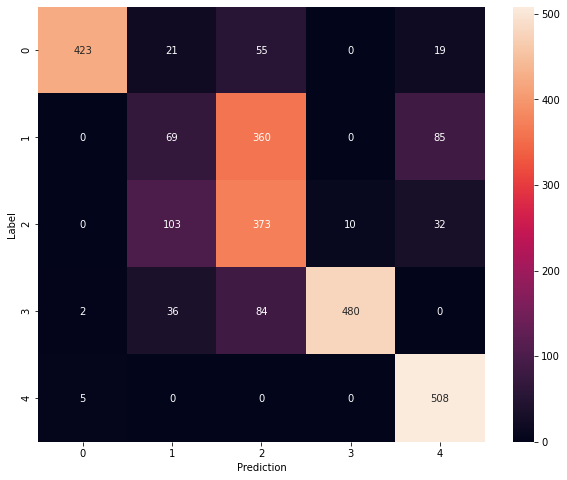

Model: "sequential_233"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_233 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 125)               1625      
_________________________________________________________________
dropout_233 (Dropout)        (None, 125)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 630       
Total params: 2,255
Trainable params: 2,255
Non-trainable params: 0
_________________________________________________________________
31 out of 100 runs
Epoch 1/30
225/225 [==============================] - 1s 4ms/step - loss: 1.1966 - accuracy: 0.5135 - val_loss: 0.8466 - val_accuracy: 0.6666

Epoch 00001: val_accuracy improved from -inf to 0.66655, saving model to training_31/c

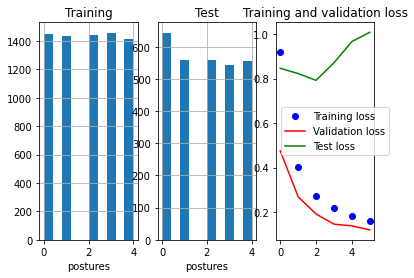

90/90 - 0s - loss: 1.0086 - accuracy: 0.7088

Test accuracy: 0.7088430523872375


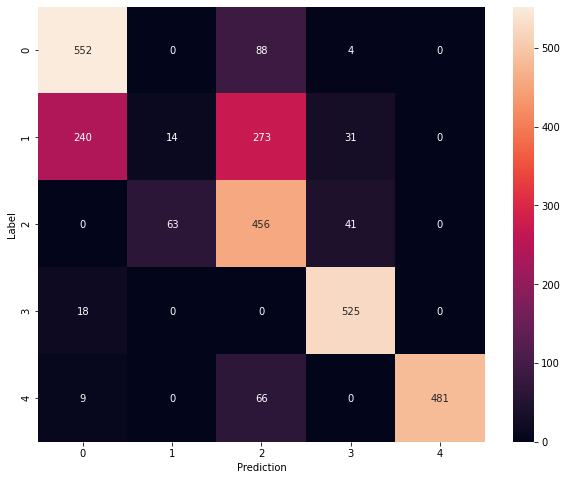

Model: "sequential_234"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_234 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 125)               1625      
_________________________________________________________________
dropout_234 (Dropout)        (None, 125)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 630       
Total params: 2,255
Trainable params: 2,255
Non-trainable params: 0
_________________________________________________________________
32 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1951 - accuracy: 0.5300 - val_loss: 0.7360 - val_accuracy: 0.7245

Epoch 00001: val_accuracy improved from -inf to 0.72449, saving model to training_32/c

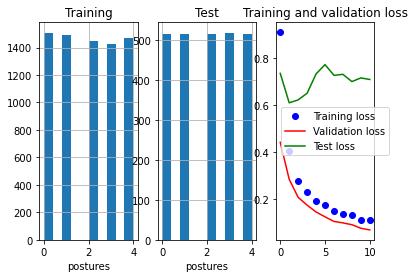

81/81 - 0s - loss: 0.7100 - accuracy: 0.8304

Test accuracy: 0.8304229974746704


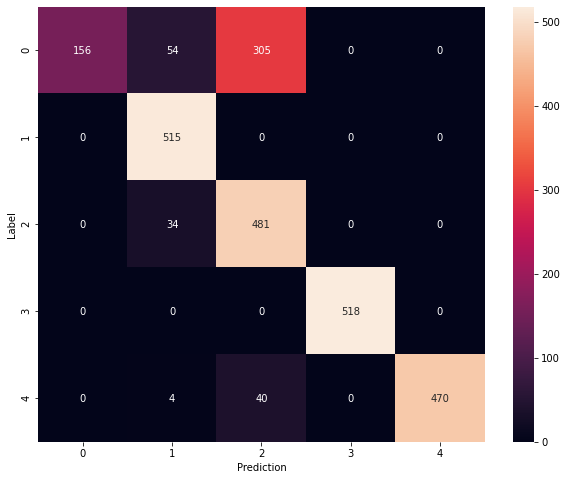

Model: "sequential_235"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_235 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 125)               1625      
_________________________________________________________________
dropout_235 (Dropout)        (None, 125)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 630       
Total params: 2,255
Trainable params: 2,255
Non-trainable params: 0
_________________________________________________________________
33 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1540 - accuracy: 0.5205 - val_loss: 1.2951 - val_accuracy: 0.5403

Epoch 00001: val_accuracy improved from -inf to 0.54034, saving model to training_33/c

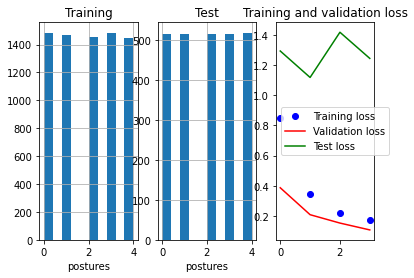

81/81 - 0s - loss: 1.2460 - accuracy: 0.5663

Test accuracy: 0.5663304924964905


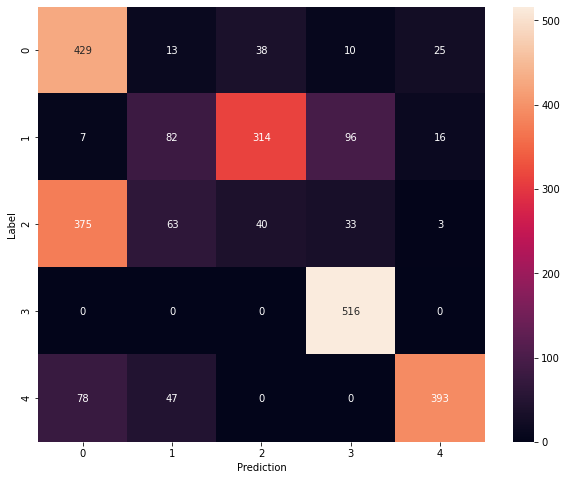

Model: "sequential_236"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_236 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 125)               1625      
_________________________________________________________________
dropout_236 (Dropout)        (None, 125)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 630       
Total params: 2,255
Trainable params: 2,255
Non-trainable params: 0
_________________________________________________________________
34 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1328 - accuracy: 0.5537 - val_loss: 0.9820 - val_accuracy: 0.6690

Epoch 00001: val_accuracy improved from -inf to 0.66900, saving model to training_34/c

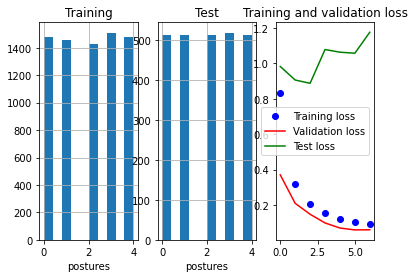

81/81 - 0s - loss: 1.1754 - accuracy: 0.6954

Test accuracy: 0.6954492330551147


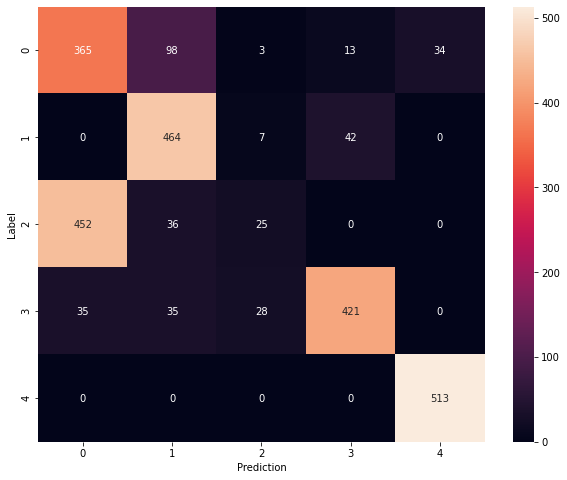

Model: "sequential_237"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_237 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 125)               1625      
_________________________________________________________________
dropout_237 (Dropout)        (None, 125)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 630       
Total params: 2,255
Trainable params: 2,255
Non-trainable params: 0
_________________________________________________________________
35 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1711 - accuracy: 0.5297 - val_loss: 1.2540 - val_accuracy: 0.5347

Epoch 00001: val_accuracy improved from -inf to 0.53471, saving model to training_35/c

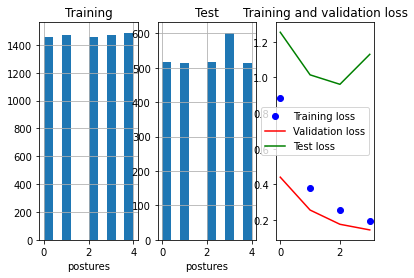

84/84 - 0s - loss: 1.1299 - accuracy: 0.6454

Test accuracy: 0.6454033851623535


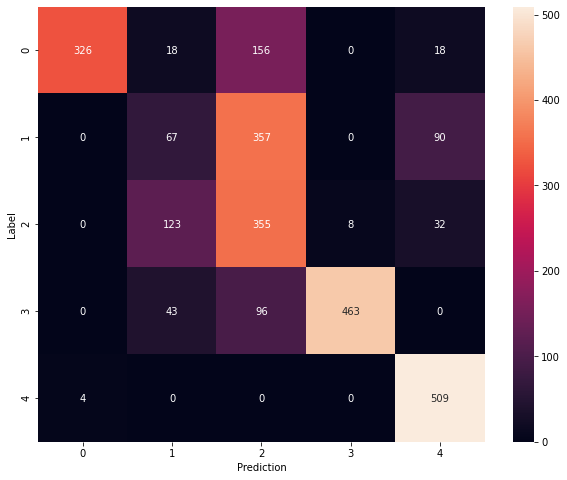

Model: "sequential_238"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_238 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 125)               1625      
_________________________________________________________________
dropout_238 (Dropout)        (None, 125)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 630       
Total params: 2,255
Trainable params: 2,255
Non-trainable params: 0
_________________________________________________________________
36 out of 100 runs
Epoch 1/30
225/225 [==============================] - 1s 4ms/step - loss: 1.1844 - accuracy: 0.5224 - val_loss: 0.8977 - val_accuracy: 0.6498

Epoch 00001: val_accuracy improved from -inf to 0.64977, saving model to training_36/c

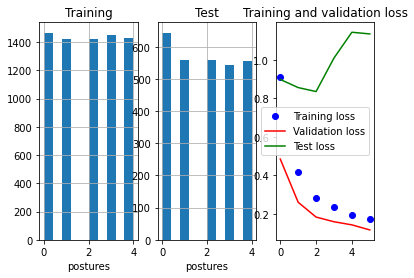

90/90 - 0s - loss: 1.1342 - accuracy: 0.7081

Test accuracy: 0.7081440091133118


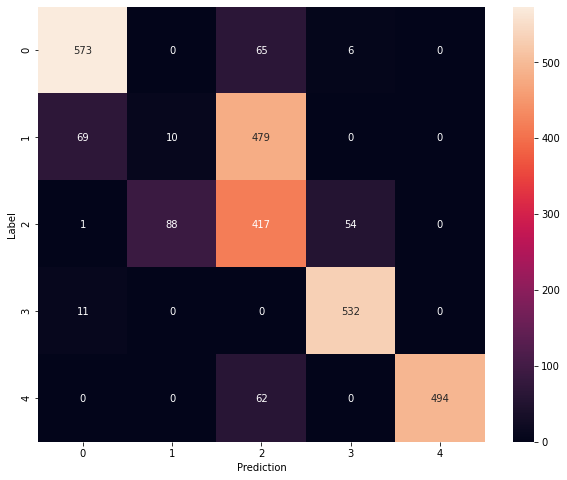

Model: "sequential_239"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_239 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 125)               1625      
_________________________________________________________________
dropout_239 (Dropout)        (None, 125)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 630       
Total params: 2,255
Trainable params: 2,255
Non-trainable params: 0
_________________________________________________________________
37 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1845 - accuracy: 0.5343 - val_loss: 0.8362 - val_accuracy: 0.6632

Epoch 00001: val_accuracy improved from -inf to 0.66317, saving model to training_37/c

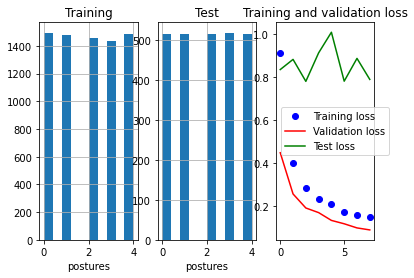

81/81 - 0s - loss: 0.7904 - accuracy: 0.7908

Test accuracy: 0.7908420562744141


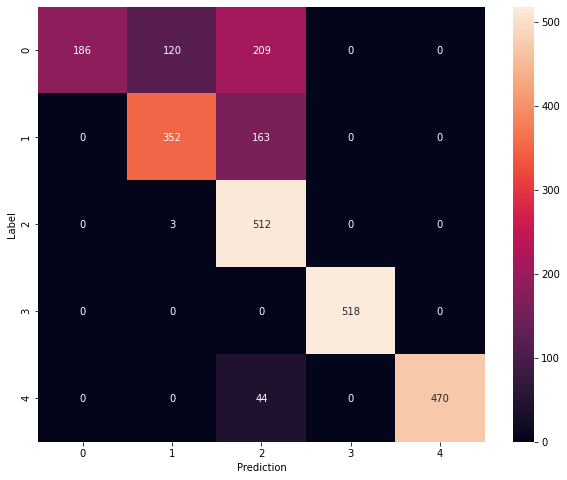

Model: "sequential_240"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_240 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 125)               1625      
_________________________________________________________________
dropout_240 (Dropout)        (None, 125)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 630       
Total params: 2,255
Trainable params: 2,255
Non-trainable params: 0
_________________________________________________________________
38 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1163 - accuracy: 0.5508 - val_loss: 1.2657 - val_accuracy: 0.5217

Epoch 00001: val_accuracy improved from -inf to 0.52172, saving model to training_38/c

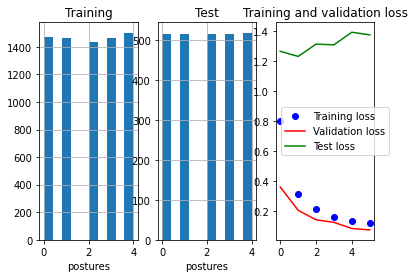

81/81 - 0s - loss: 1.3748 - accuracy: 0.5667

Test accuracy: 0.5667183995246887


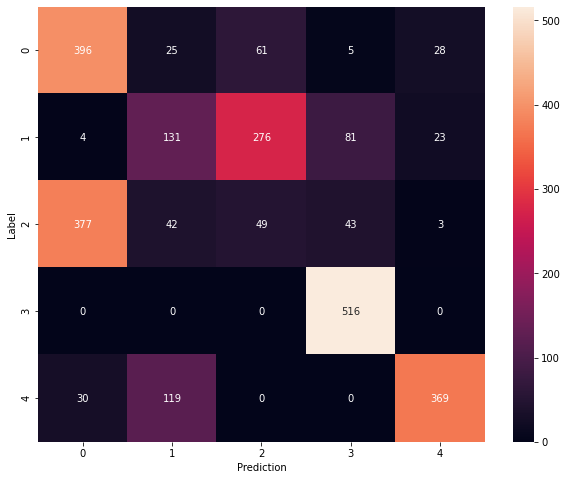

Model: "sequential_241"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_241 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 125)               1625      
_________________________________________________________________
dropout_241 (Dropout)        (None, 125)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 630       
Total params: 2,255
Trainable params: 2,255
Non-trainable params: 0
_________________________________________________________________
39 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1518 - accuracy: 0.5317 - val_loss: 1.2923 - val_accuracy: 0.5628

Epoch 00001: val_accuracy improved from -inf to 0.56282, saving model to training_39/c

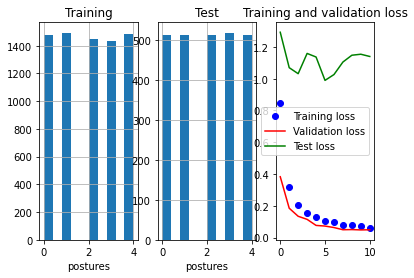

81/81 - 0s - loss: 1.1399 - accuracy: 0.7168

Test accuracy: 0.7168416976928711


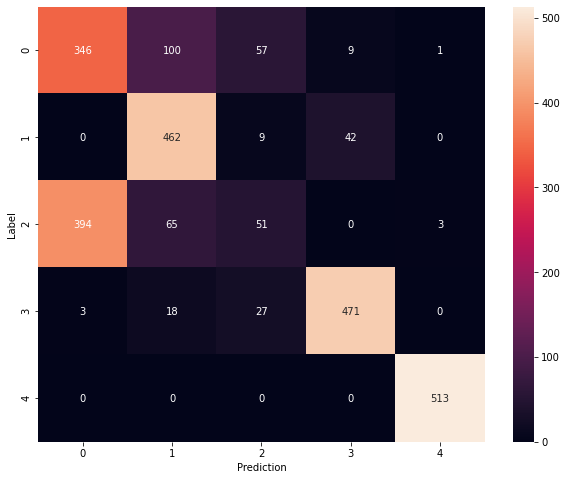

Model: "sequential_242"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_242 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 130)               1690      
_________________________________________________________________
dropout_242 (Dropout)        (None, 130)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 655       
Total params: 2,345
Trainable params: 2,345
Non-trainable params: 0
_________________________________________________________________
40 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1416 - accuracy: 0.5449 - val_loss: 1.2270 - val_accuracy: 0.5490

Epoch 00001: val_accuracy improved from -inf to 0.54897, saving model to training_40/c

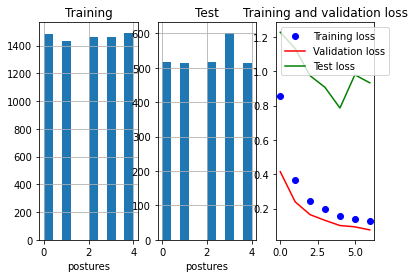

84/84 - 0s - loss: 0.9327 - accuracy: 0.7163

Test accuracy: 0.7163227200508118


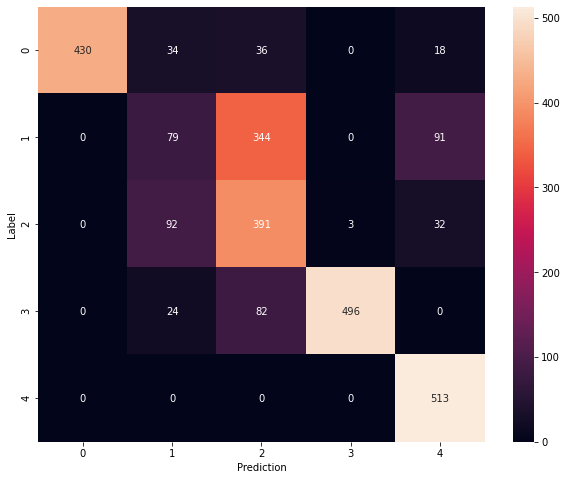

Model: "sequential_243"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_243 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 130)               1690      
_________________________________________________________________
dropout_243 (Dropout)        (None, 130)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 655       
Total params: 2,345
Trainable params: 2,345
Non-trainable params: 0
_________________________________________________________________
41 out of 100 runs
Epoch 1/30
225/225 [==============================] - 1s 4ms/step - loss: 1.1963 - accuracy: 0.5151 - val_loss: 0.8713 - val_accuracy: 0.7127

Epoch 00001: val_accuracy improved from -inf to 0.71269, saving model to training_41/c

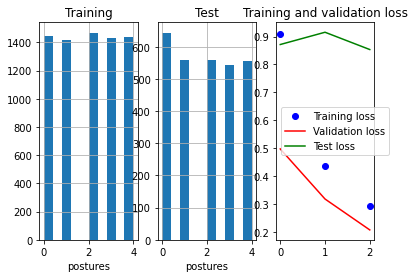

90/90 - 0s - loss: 0.8533 - accuracy: 0.7029

Test accuracy: 0.7029010653495789


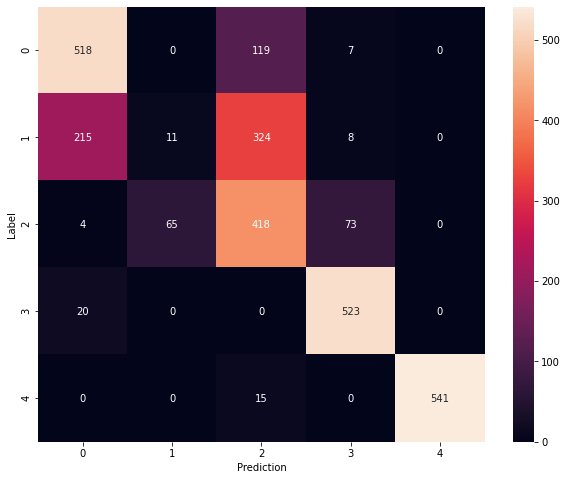

Model: "sequential_244"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_244 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 130)               1690      
_________________________________________________________________
dropout_244 (Dropout)        (None, 130)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 655       
Total params: 2,345
Trainable params: 2,345
Non-trainable params: 0
_________________________________________________________________
42 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1572 - accuracy: 0.5411 - val_loss: 0.9431 - val_accuracy: 0.6329

Epoch 00001: val_accuracy improved from -inf to 0.63291, saving model to training_42/c

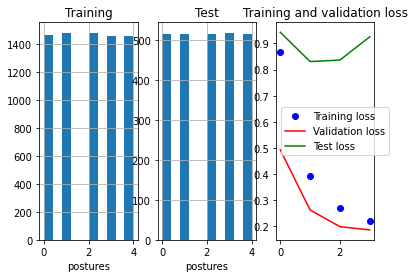

81/81 - 0s - loss: 0.9256 - accuracy: 0.6570

Test accuracy: 0.656965434551239


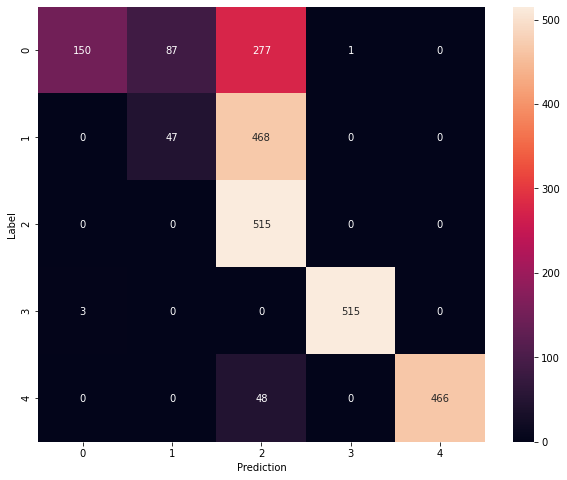

Model: "sequential_245"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_245 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 130)               1690      
_________________________________________________________________
dropout_245 (Dropout)        (None, 130)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 655       
Total params: 2,345
Trainable params: 2,345
Non-trainable params: 0
_________________________________________________________________
43 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1342 - accuracy: 0.5428 - val_loss: 1.3333 - val_accuracy: 0.5295

Epoch 00001: val_accuracy improved from -inf to 0.52948, saving model to training_43/c

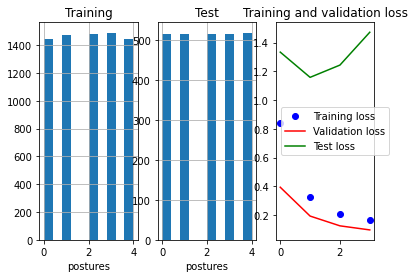

81/81 - 0s - loss: 1.4716 - accuracy: 0.5721

Test accuracy: 0.5721489787101746


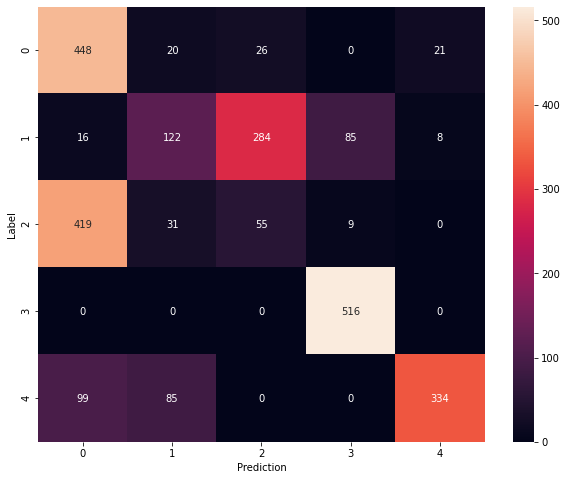

Model: "sequential_246"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_246 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 130)               1690      
_________________________________________________________________
dropout_246 (Dropout)        (None, 130)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 655       
Total params: 2,345
Trainable params: 2,345
Non-trainable params: 0
_________________________________________________________________
44 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1205 - accuracy: 0.5529 - val_loss: 1.1484 - val_accuracy: 0.5722

Epoch 00001: val_accuracy improved from -inf to 0.57215, saving model to training_44/c

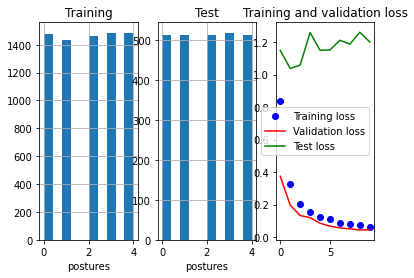

81/81 - 0s - loss: 1.2008 - accuracy: 0.7102

Test accuracy: 0.7102294564247131


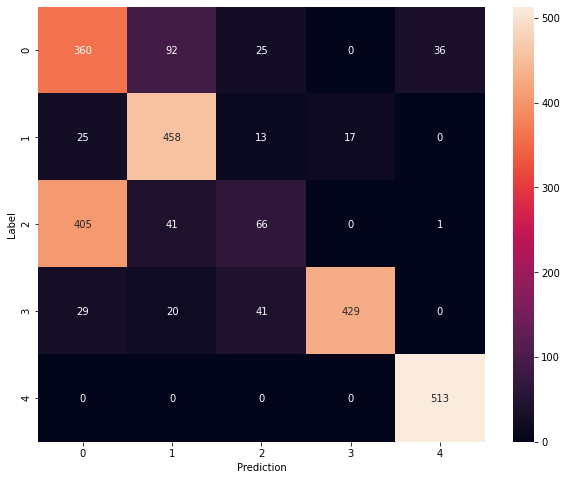

Model: "sequential_247"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_247 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 130)               1690      
_________________________________________________________________
dropout_247 (Dropout)        (None, 130)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 655       
Total params: 2,345
Trainable params: 2,345
Non-trainable params: 0
_________________________________________________________________
45 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1410 - accuracy: 0.5461 - val_loss: 1.1861 - val_accuracy: 0.5231

Epoch 00001: val_accuracy improved from -inf to 0.52308, saving model to training_45/c

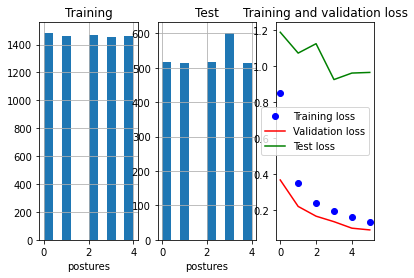

84/84 - 0s - loss: 0.9632 - accuracy: 0.7006

Test accuracy: 0.7005628347396851


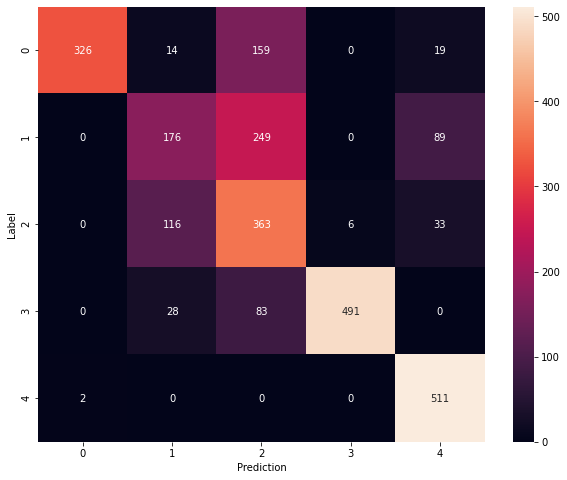

Model: "sequential_248"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_248 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 130)               1690      
_________________________________________________________________
dropout_248 (Dropout)        (None, 130)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 655       
Total params: 2,345
Trainable params: 2,345
Non-trainable params: 0
_________________________________________________________________
46 out of 100 runs
Epoch 1/30
225/225 [==============================] - 1s 4ms/step - loss: 1.1937 - accuracy: 0.5166 - val_loss: 0.8667 - val_accuracy: 0.6361

Epoch 00001: val_accuracy improved from -inf to 0.63614, saving model to training_46/c

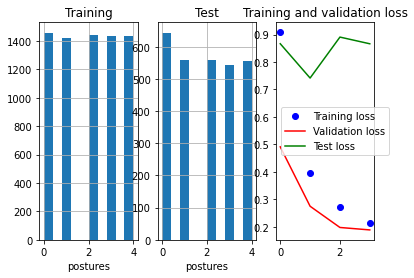

90/90 - 0s - loss: 0.8665 - accuracy: 0.6809

Test accuracy: 0.6808807849884033


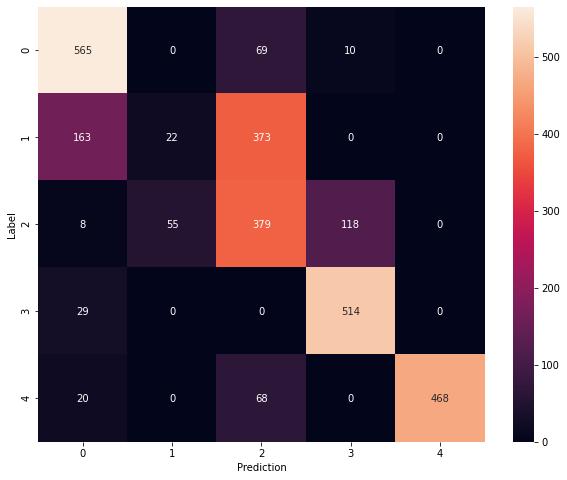

Model: "sequential_249"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_249 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 130)               1690      
_________________________________________________________________
dropout_249 (Dropout)        (None, 130)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 655       
Total params: 2,345
Trainable params: 2,345
Non-trainable params: 0
_________________________________________________________________
47 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1704 - accuracy: 0.5540 - val_loss: 0.9379 - val_accuracy: 0.5902

Epoch 00001: val_accuracy improved from -inf to 0.59022, saving model to training_47/c

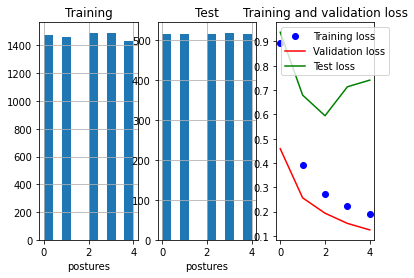

81/81 - 0s - loss: 0.7408 - accuracy: 0.7540

Test accuracy: 0.7539774775505066


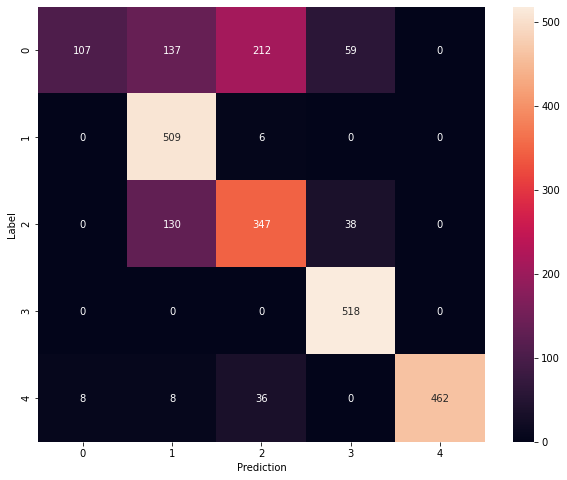

Model: "sequential_250"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_250 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 130)               1690      
_________________________________________________________________
dropout_250 (Dropout)        (None, 130)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 655       
Total params: 2,345
Trainable params: 2,345
Non-trainable params: 0
_________________________________________________________________
48 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1255 - accuracy: 0.5504 - val_loss: 1.2977 - val_accuracy: 0.5388

Epoch 00001: val_accuracy improved from -inf to 0.53879, saving model to training_48/c

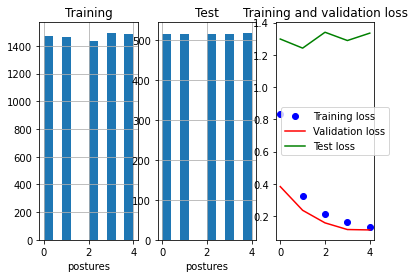

81/81 - 0s - loss: 1.3341 - accuracy: 0.5601

Test accuracy: 0.5601240992546082


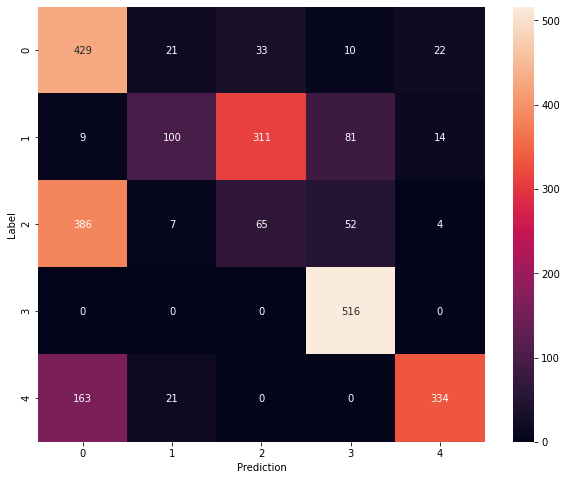

Model: "sequential_251"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_251 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 130)               1690      
_________________________________________________________________
dropout_251 (Dropout)        (None, 130)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 655       
Total params: 2,345
Trainable params: 2,345
Non-trainable params: 0
_________________________________________________________________
49 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1311 - accuracy: 0.5402 - val_loss: 1.0344 - val_accuracy: 0.6807

Epoch 00001: val_accuracy improved from -inf to 0.68067, saving model to training_49/c

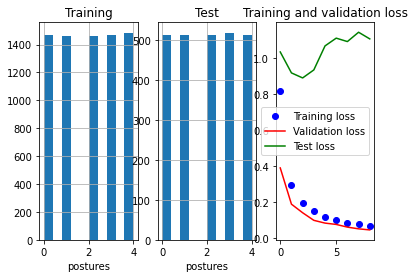

81/81 - 0s - loss: 1.1070 - accuracy: 0.7161

Test accuracy: 0.7160637974739075


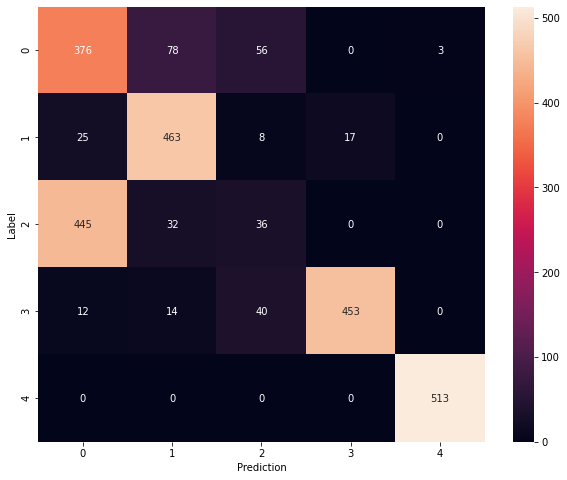

Model: "sequential_252"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_252 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 135)               1755      
_________________________________________________________________
dropout_252 (Dropout)        (None, 135)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 680       
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________
50 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1581 - accuracy: 0.5443 - val_loss: 1.3921 - val_accuracy: 0.4615

Epoch 00001: val_accuracy improved from -inf to 0.46154, saving model to training_50/c

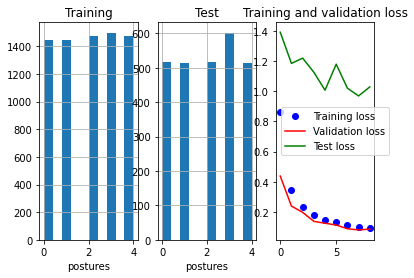

84/84 - 0s - loss: 1.0291 - accuracy: 0.7088

Test accuracy: 0.7088180184364319


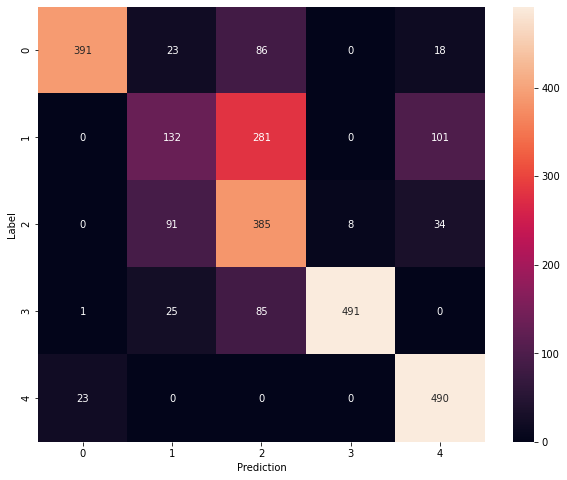

Model: "sequential_253"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_253 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 135)               1755      
_________________________________________________________________
dropout_253 (Dropout)        (None, 135)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 680       
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________
51 out of 100 runs
Epoch 1/30
225/225 [==============================] - 1s 3ms/step - loss: 1.1720 - accuracy: 0.5197 - val_loss: 0.8946 - val_accuracy: 0.6620

Epoch 00001: val_accuracy improved from -inf to 0.66201, saving model to training_51/c

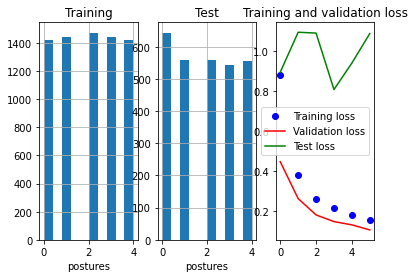

90/90 - 0s - loss: 1.0877 - accuracy: 0.6823

Test accuracy: 0.6822789311408997


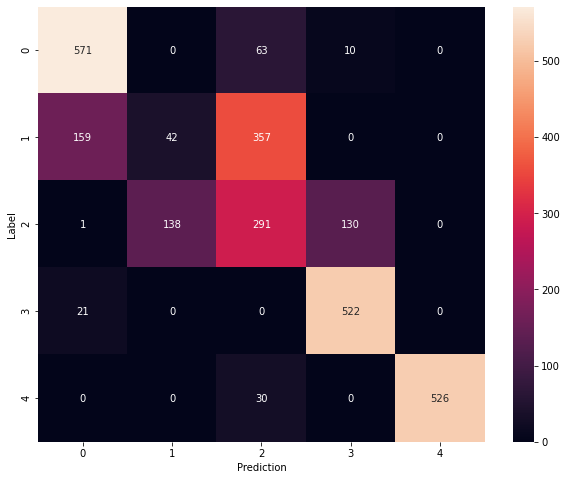

Model: "sequential_254"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_254 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 135)               1755      
_________________________________________________________________
dropout_254 (Dropout)        (None, 135)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 680       
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________
52 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1543 - accuracy: 0.5525 - val_loss: 0.8918 - val_accuracy: 0.7218

Epoch 00001: val_accuracy improved from -inf to 0.72177, saving model to training_52/c

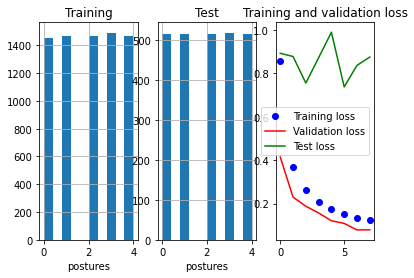

81/81 - 0s - loss: 0.8745 - accuracy: 0.7804

Test accuracy: 0.7803647518157959


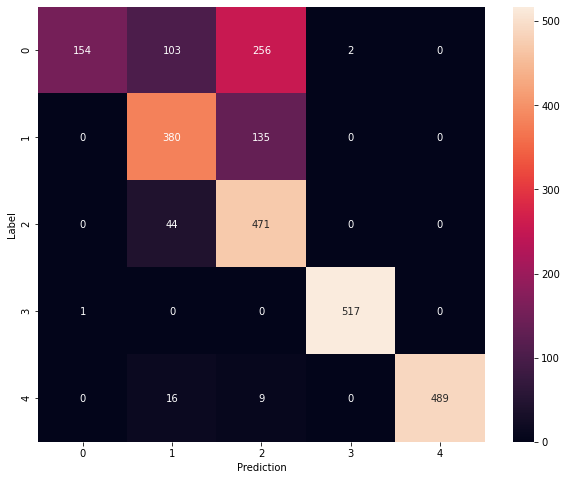

Model: "sequential_255"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_255 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 135)               1755      
_________________________________________________________________
dropout_255 (Dropout)        (None, 135)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 680       
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________
53 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1137 - accuracy: 0.5462 - val_loss: 1.3078 - val_accuracy: 0.5411

Epoch 00001: val_accuracy improved from -inf to 0.54112, saving model to training_53/c

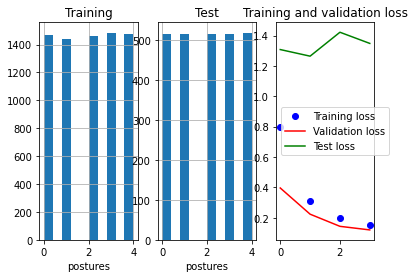

81/81 - 0s - loss: 1.3483 - accuracy: 0.6137

Test accuracy: 0.6136540174484253


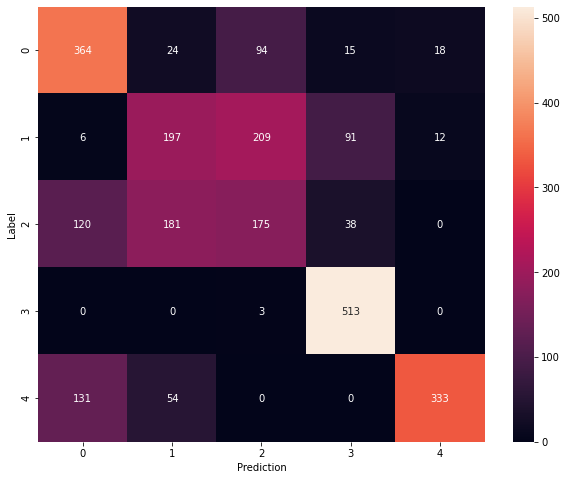

Model: "sequential_256"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_256 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 135)               1755      
_________________________________________________________________
dropout_256 (Dropout)        (None, 135)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 680       
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________
54 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1236 - accuracy: 0.5563 - val_loss: 1.1181 - val_accuracy: 0.6231

Epoch 00001: val_accuracy improved from -inf to 0.62310, saving model to training_54/c

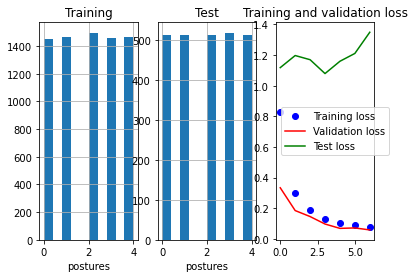

81/81 - 0s - loss: 1.3492 - accuracy: 0.7060

Test accuracy: 0.7059509754180908


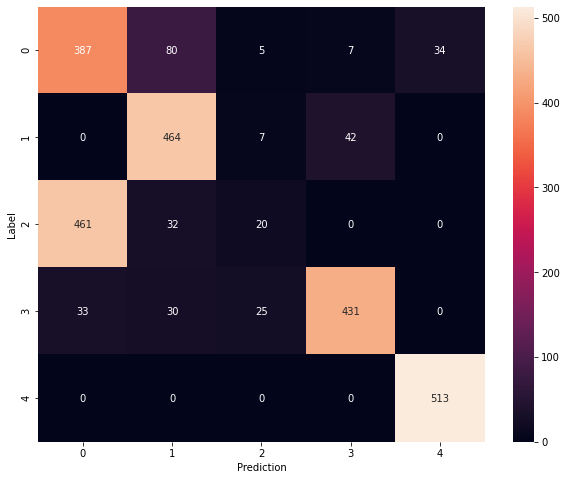

Model: "sequential_257"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_257 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 135)               1755      
_________________________________________________________________
dropout_257 (Dropout)        (None, 135)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 680       
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________
55 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1188 - accuracy: 0.5520 - val_loss: 1.2868 - val_accuracy: 0.5156

Epoch 00001: val_accuracy improved from -inf to 0.51557, saving model to training_55/c

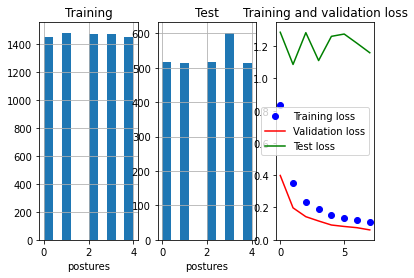

84/84 - 0s - loss: 1.1597 - accuracy: 0.6799

Test accuracy: 0.6799249649047852


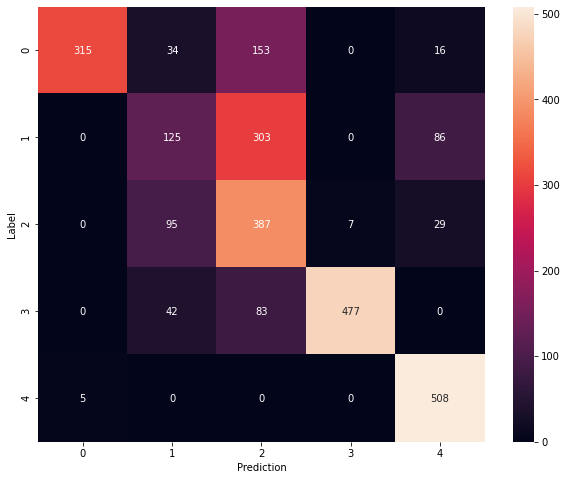

Model: "sequential_258"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_258 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 135)               1755      
_________________________________________________________________
dropout_258 (Dropout)        (None, 135)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 680       
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________
56 out of 100 runs
Epoch 1/30
225/225 [==============================] - 1s 3ms/step - loss: 1.1635 - accuracy: 0.5402 - val_loss: 1.1437 - val_accuracy: 0.5435

Epoch 00001: val_accuracy improved from -inf to 0.54352, saving model to training_56/c

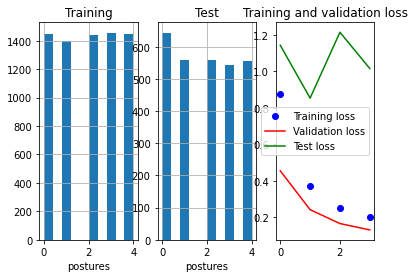

90/90 - 0s - loss: 1.0162 - accuracy: 0.7092

Test accuracy: 0.7091925740242004


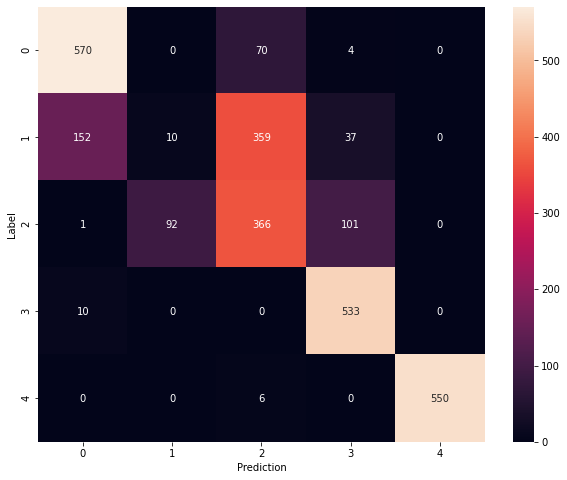

Model: "sequential_259"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_259 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 135)               1755      
_________________________________________________________________
dropout_259 (Dropout)        (None, 135)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 680       
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________
57 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1873 - accuracy: 0.5237 - val_loss: 0.9017 - val_accuracy: 0.7043

Epoch 00001: val_accuracy improved from -inf to 0.70431, saving model to training_57/c

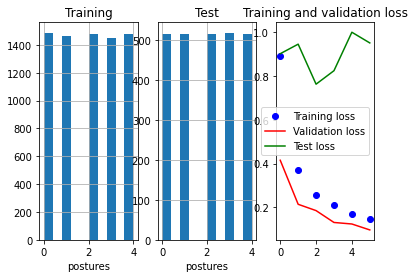

81/81 - 0s - loss: 0.9510 - accuracy: 0.7656

Test accuracy: 0.7656189203262329


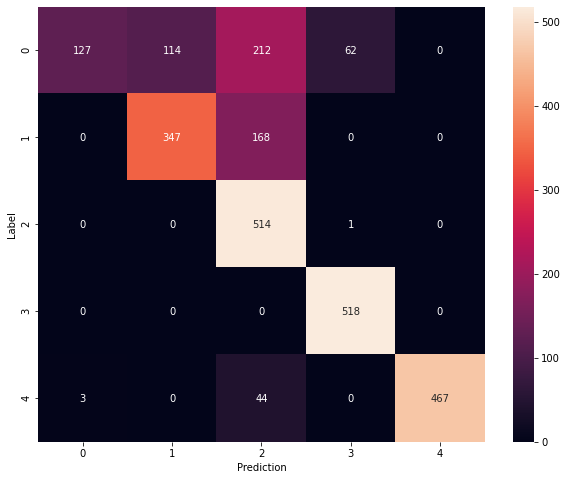

Model: "sequential_260"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_260 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 135)               1755      
_________________________________________________________________
dropout_260 (Dropout)        (None, 135)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 680       
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________
58 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1394 - accuracy: 0.5397 - val_loss: 1.2842 - val_accuracy: 0.5388

Epoch 00001: val_accuracy improved from -inf to 0.53879, saving model to training_58/c

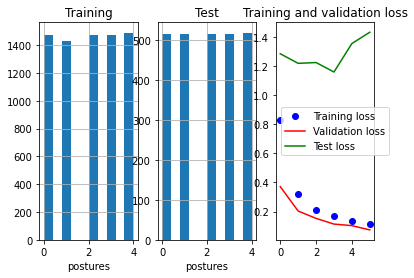

81/81 - 0s - loss: 1.4320 - accuracy: 0.5811

Test accuracy: 0.581070601940155


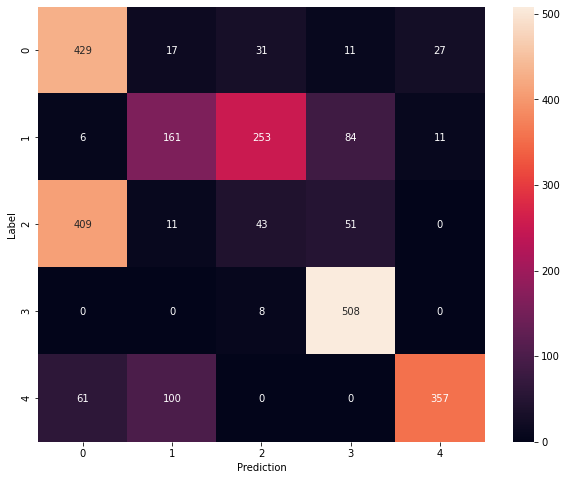

Model: "sequential_261"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_261 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 135)               1755      
_________________________________________________________________
dropout_261 (Dropout)        (None, 135)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 680       
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________
59 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1167 - accuracy: 0.5587 - val_loss: 1.2572 - val_accuracy: 0.6398

Epoch 00001: val_accuracy improved from -inf to 0.63983, saving model to training_59/c

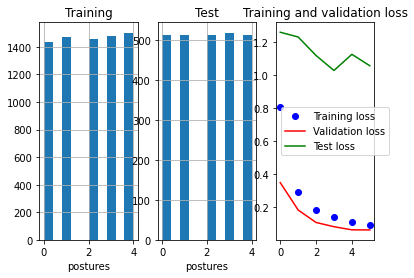

81/81 - 0s - loss: 1.0550 - accuracy: 0.6873

Test accuracy: 0.6872811913490295


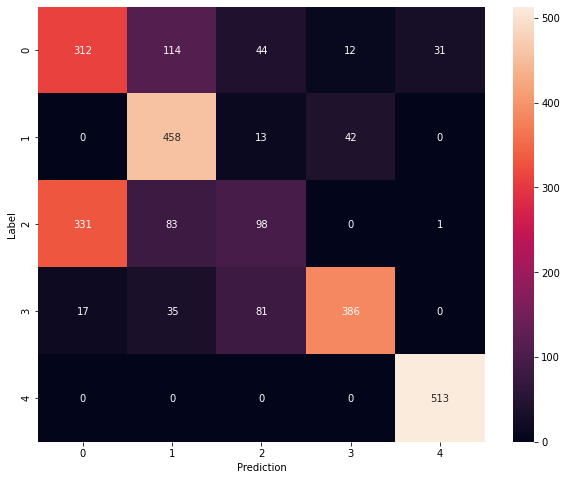

Model: "sequential_262"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_262 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 140)               1820      
_________________________________________________________________
dropout_262 (Dropout)        (None, 140)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 705       
Total params: 2,525
Trainable params: 2,525
Non-trainable params: 0
_________________________________________________________________
60 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1361 - accuracy: 0.5441 - val_loss: 1.2381 - val_accuracy: 0.5373

Epoch 00001: val_accuracy improved from -inf to 0.53734, saving model to training_60/c

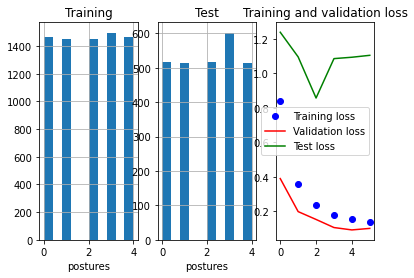

84/84 - 0s - loss: 1.1044 - accuracy: 0.7013

Test accuracy: 0.701313316822052


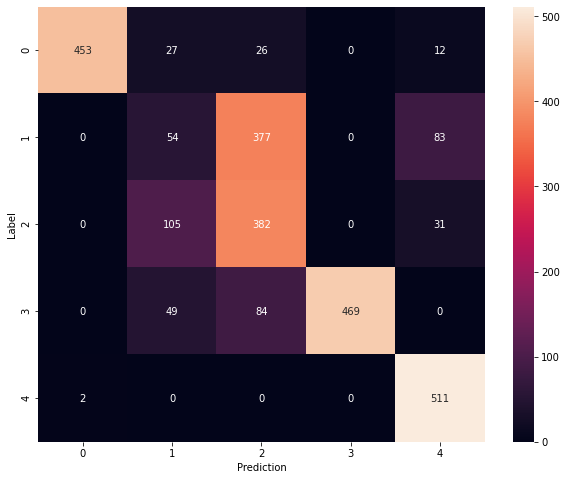

Model: "sequential_263"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_263 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 140)               1820      
_________________________________________________________________
dropout_263 (Dropout)        (None, 140)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 705       
Total params: 2,525
Trainable params: 2,525
Non-trainable params: 0
_________________________________________________________________
61 out of 100 runs
Epoch 1/30
225/225 [==============================] - 1s 3ms/step - loss: 1.1769 - accuracy: 0.5145 - val_loss: 0.8648 - val_accuracy: 0.6274

Epoch 00001: val_accuracy improved from -inf to 0.62740, saving model to training_61/c

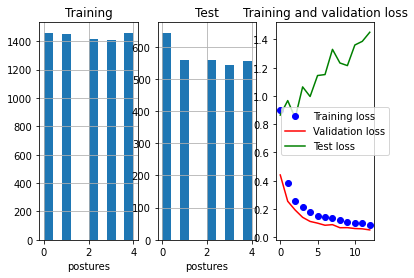

90/90 - 0s - loss: 1.4511 - accuracy: 0.7455

Test accuracy: 0.7455435395240784


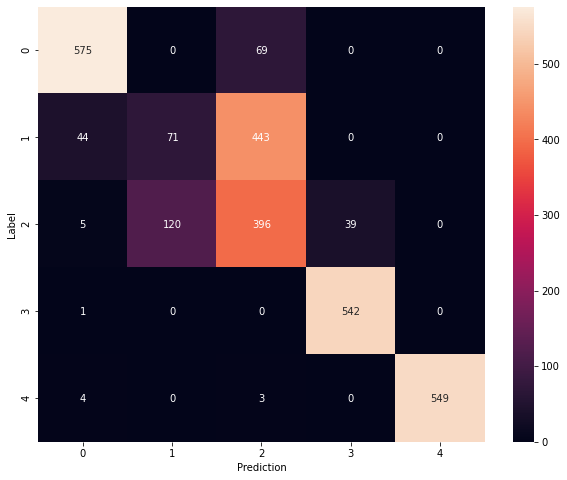

Model: "sequential_264"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_264 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 140)               1820      
_________________________________________________________________
dropout_264 (Dropout)        (None, 140)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 705       
Total params: 2,525
Trainable params: 2,525
Non-trainable params: 0
_________________________________________________________________
62 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1592 - accuracy: 0.5475 - val_loss: 0.7163 - val_accuracy: 0.7804

Epoch 00001: val_accuracy improved from -inf to 0.78036, saving model to training_62/c

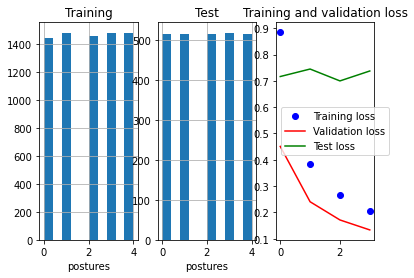

81/81 - 0s - loss: 0.7374 - accuracy: 0.7606

Test accuracy: 0.7605743408203125


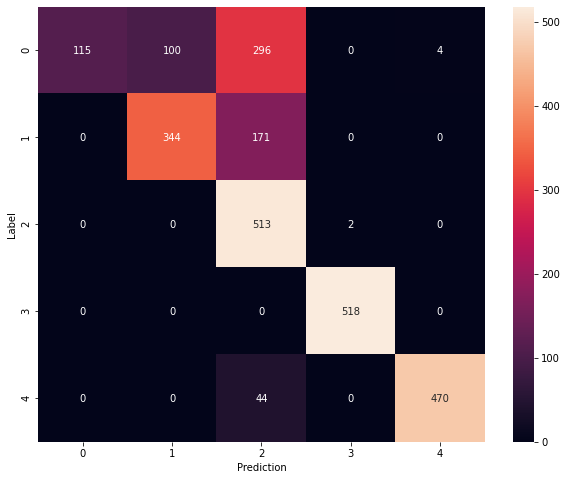

Model: "sequential_265"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_265 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 140)               1820      
_________________________________________________________________
dropout_265 (Dropout)        (None, 140)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 705       
Total params: 2,525
Trainable params: 2,525
Non-trainable params: 0
_________________________________________________________________
63 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.0830 - accuracy: 0.5786 - val_loss: 1.1213 - val_accuracy: 0.5927

Epoch 00001: val_accuracy improved from -inf to 0.59271, saving model to training_63/c

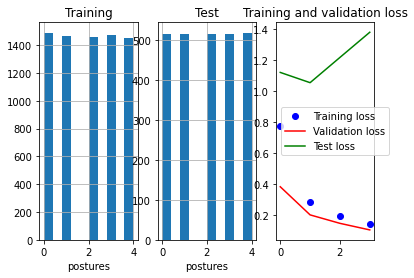

81/81 - 0s - loss: 1.3811 - accuracy: 0.5892

Test accuracy: 0.5892164707183838


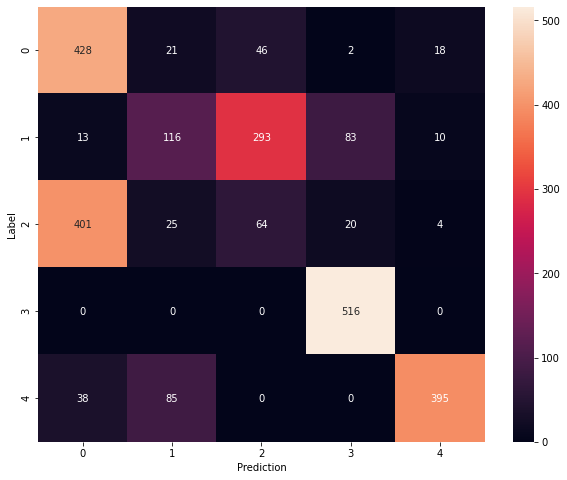

Model: "sequential_266"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_266 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 140)               1820      
_________________________________________________________________
dropout_266 (Dropout)        (None, 140)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 705       
Total params: 2,525
Trainable params: 2,525
Non-trainable params: 0
_________________________________________________________________
64 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1069 - accuracy: 0.5517 - val_loss: 1.0661 - val_accuracy: 0.6468

Epoch 00001: val_accuracy improved from -inf to 0.64683, saving model to training_64/c

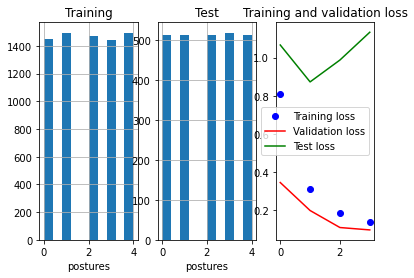

81/81 - 0s - loss: 1.1329 - accuracy: 0.6807

Test accuracy: 0.6806690096855164


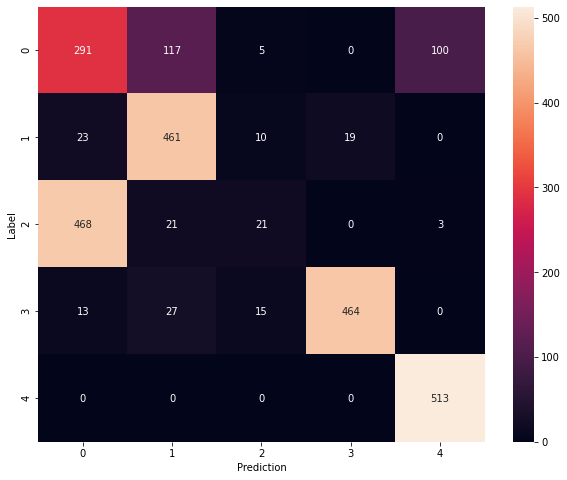

Model: "sequential_267"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_267 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 140)               1820      
_________________________________________________________________
dropout_267 (Dropout)        (None, 140)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 705       
Total params: 2,525
Trainable params: 2,525
Non-trainable params: 0
_________________________________________________________________
65 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1391 - accuracy: 0.5388 - val_loss: 1.1202 - val_accuracy: 0.6248

Epoch 00001: val_accuracy improved from -inf to 0.62477, saving model to training_65/c

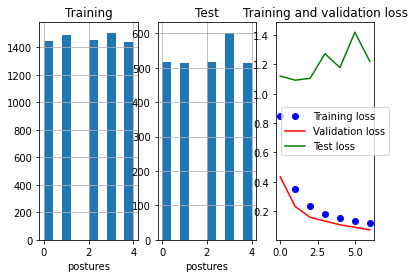

84/84 - 0s - loss: 1.2210 - accuracy: 0.6979

Test accuracy: 0.6979362368583679


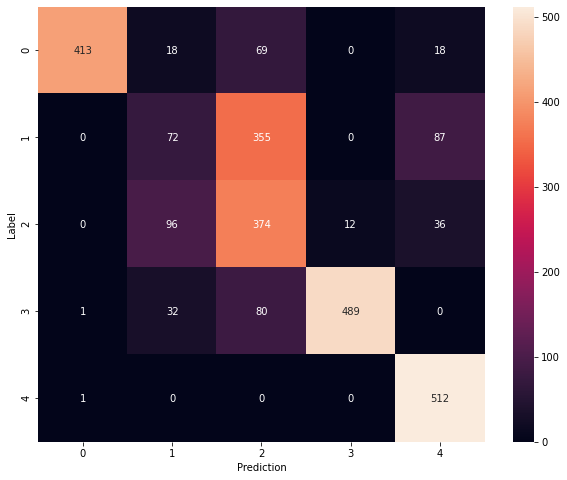

Model: "sequential_268"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_268 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 140)               1820      
_________________________________________________________________
dropout_268 (Dropout)        (None, 140)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 705       
Total params: 2,525
Trainable params: 2,525
Non-trainable params: 0
_________________________________________________________________
66 out of 100 runs
Epoch 1/30
225/225 [==============================] - 1s 4ms/step - loss: 1.1566 - accuracy: 0.5323 - val_loss: 0.8549 - val_accuracy: 0.6631

Epoch 00001: val_accuracy improved from -inf to 0.66305, saving model to training_66/c

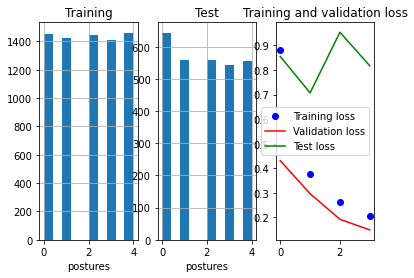

90/90 - 0s - loss: 0.8169 - accuracy: 0.7281

Test accuracy: 0.7280671000480652


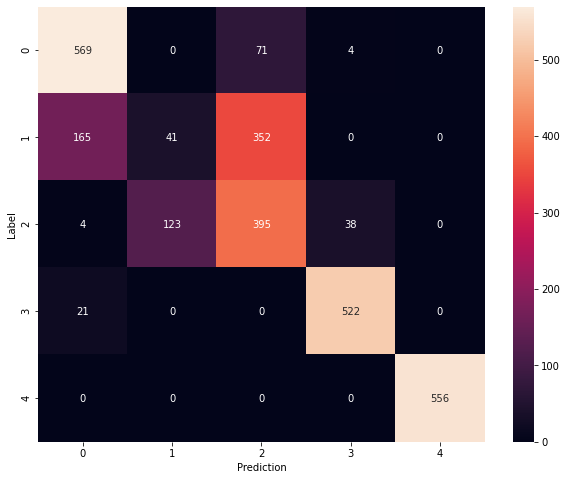

Model: "sequential_269"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_269 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 140)               1820      
_________________________________________________________________
dropout_269 (Dropout)        (None, 140)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 705       
Total params: 2,525
Trainable params: 2,525
Non-trainable params: 0
_________________________________________________________________
67 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.1499 - accuracy: 0.5432 - val_loss: 0.9412 - val_accuracy: 0.7291

Epoch 00001: val_accuracy improved from -inf to 0.72914, saving model to training_67/c

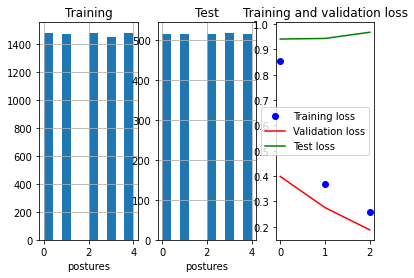

81/81 - 0s - loss: 0.9681 - accuracy: 0.6356

Test accuracy: 0.6356227993965149


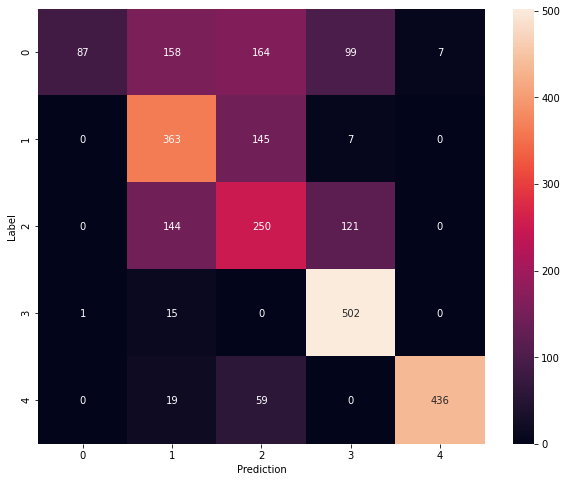

Model: "sequential_270"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_270 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 140)               1820      
_________________________________________________________________
dropout_270 (Dropout)        (None, 140)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 705       
Total params: 2,525
Trainable params: 2,525
Non-trainable params: 0
_________________________________________________________________
68 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.0932 - accuracy: 0.5550 - val_loss: 1.2718 - val_accuracy: 0.5520

Epoch 00001: val_accuracy improved from -inf to 0.55198, saving model to training_68/c

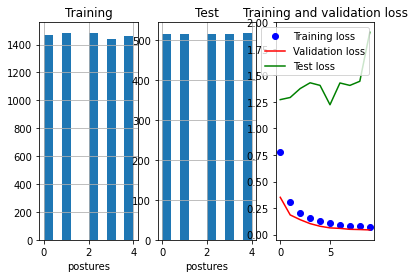

81/81 - 0s - loss: 1.9070 - accuracy: 0.5706

Test accuracy: 0.5705973505973816


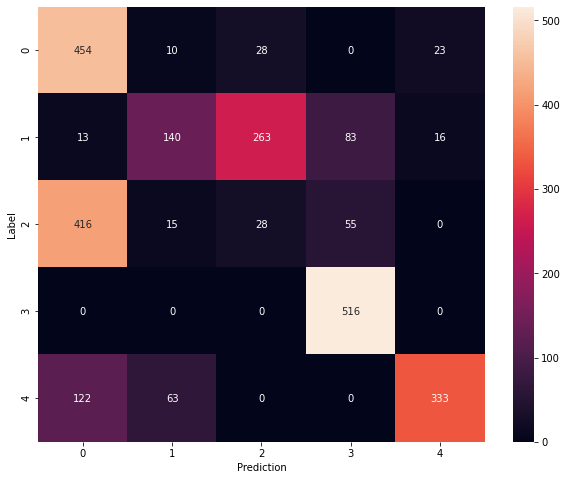

Model: "sequential_271"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_271 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 140)               1820      
_________________________________________________________________
dropout_271 (Dropout)        (None, 140)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 705       
Total params: 2,525
Trainable params: 2,525
Non-trainable params: 0
_________________________________________________________________
69 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.0944 - accuracy: 0.5620 - val_loss: 1.0546 - val_accuracy: 0.6278

Epoch 00001: val_accuracy improved from -inf to 0.62777, saving model to training_69/c

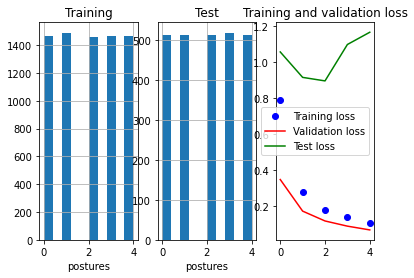

81/81 - 0s - loss: 1.1640 - accuracy: 0.6970

Test accuracy: 0.697005033493042


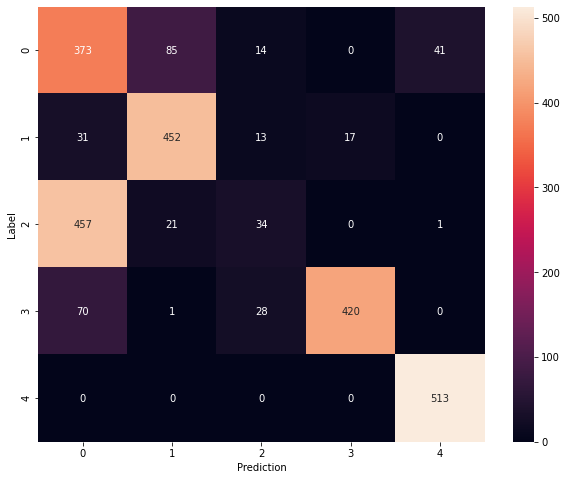

Model: "sequential_272"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_272 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 145)               1885      
_________________________________________________________________
dropout_272 (Dropout)        (None, 145)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 730       
Total params: 2,615
Trainable params: 2,615
Non-trainable params: 0
_________________________________________________________________
70 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1127 - accuracy: 0.5653 - val_loss: 1.3669 - val_accuracy: 0.5152

Epoch 00001: val_accuracy improved from -inf to 0.51520, saving model to training_70/c

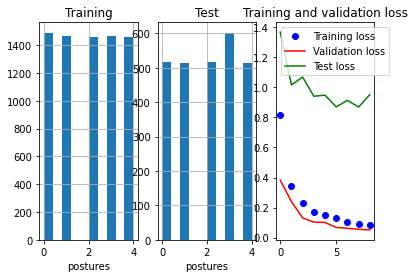

84/84 - 0s - loss: 0.9512 - accuracy: 0.7437

Test accuracy: 0.7437148094177246


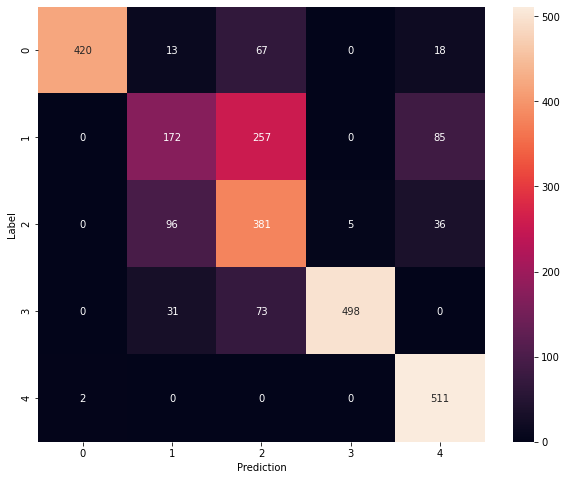

Model: "sequential_273"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_273 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 145)               1885      
_________________________________________________________________
dropout_273 (Dropout)        (None, 145)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 730       
Total params: 2,615
Trainable params: 2,615
Non-trainable params: 0
_________________________________________________________________
71 out of 100 runs
Epoch 1/30
225/225 [==============================] - 1s 4ms/step - loss: 1.1603 - accuracy: 0.5353 - val_loss: 0.9415 - val_accuracy: 0.6103

Epoch 00001: val_accuracy improved from -inf to 0.61028, saving model to training_71/c

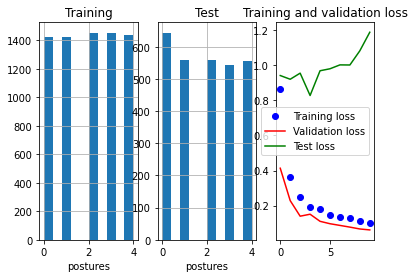

90/90 - 0s - loss: 1.1884 - accuracy: 0.7249

Test accuracy: 0.7249213457107544


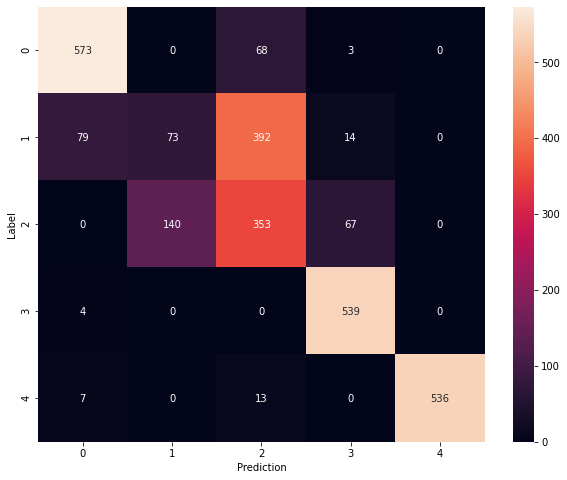

Model: "sequential_274"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_274 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 145)               1885      
_________________________________________________________________
dropout_274 (Dropout)        (None, 145)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 730       
Total params: 2,615
Trainable params: 2,615
Non-trainable params: 0
_________________________________________________________________
72 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1535 - accuracy: 0.5380 - val_loss: 1.0113 - val_accuracy: 0.5239

Epoch 00001: val_accuracy improved from -inf to 0.52386, saving model to training_72/c

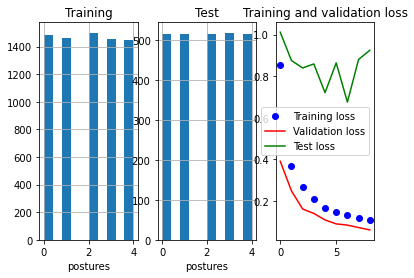

81/81 - 0s - loss: 0.9242 - accuracy: 0.8269

Test accuracy: 0.8269305229187012


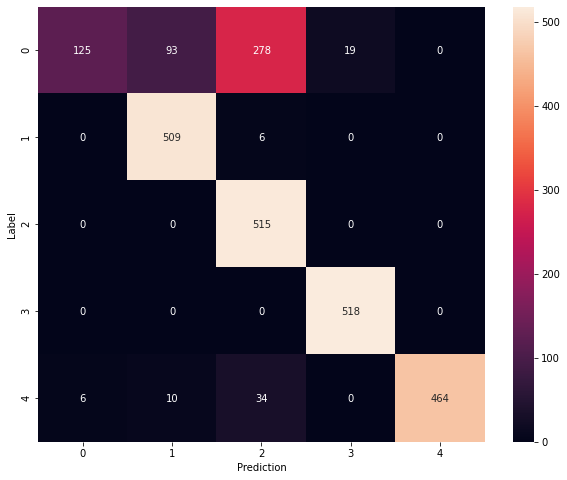

Model: "sequential_275"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_275 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 145)               1885      
_________________________________________________________________
dropout_275 (Dropout)        (None, 145)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 730       
Total params: 2,615
Trainable params: 2,615
Non-trainable params: 0
_________________________________________________________________
73 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 3ms/step - loss: 1.0920 - accuracy: 0.5642 - val_loss: 1.4009 - val_accuracy: 0.5415

Epoch 00001: val_accuracy improved from -inf to 0.54151, saving model to training_73/c

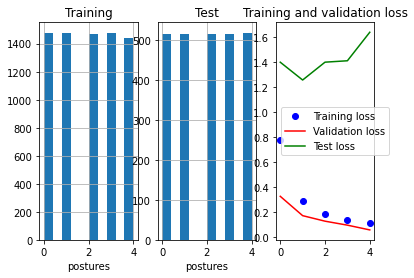

81/81 - 0s - loss: 1.6406 - accuracy: 0.5551

Test accuracy: 0.5550814867019653


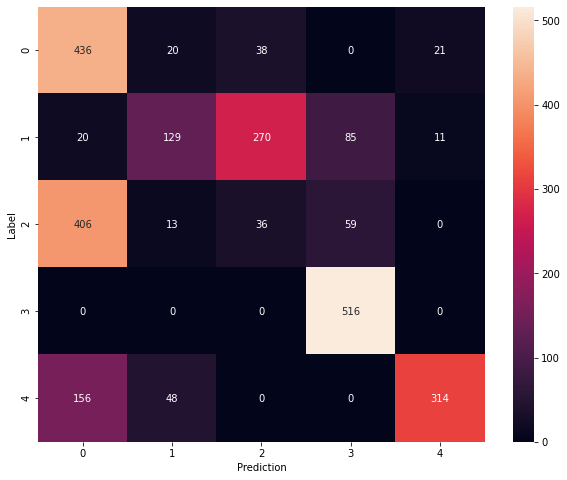

Model: "sequential_276"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_276 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 145)               1885      
_________________________________________________________________
dropout_276 (Dropout)        (None, 145)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 730       
Total params: 2,615
Trainable params: 2,615
Non-trainable params: 0
_________________________________________________________________
74 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1011 - accuracy: 0.5540 - val_loss: 1.1912 - val_accuracy: 0.5165

Epoch 00001: val_accuracy improved from -inf to 0.51653, saving model to training_74/c

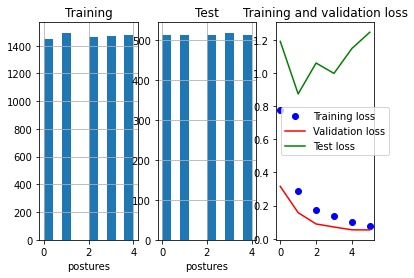

81/81 - 0s - loss: 1.2462 - accuracy: 0.6974

Test accuracy: 0.6973940134048462


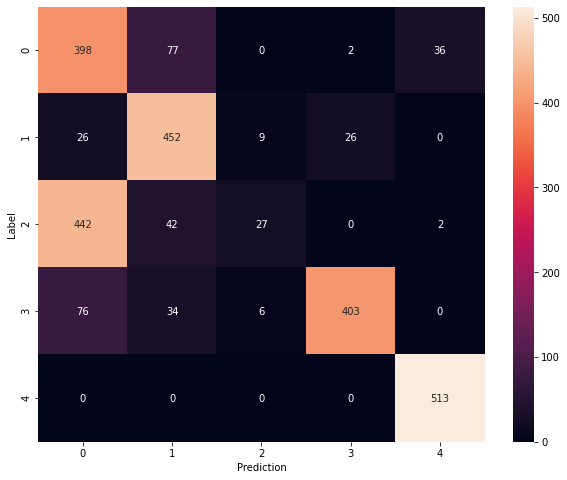

Model: "sequential_277"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_277 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 145)               1885      
_________________________________________________________________
dropout_277 (Dropout)        (None, 145)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 730       
Total params: 2,615
Trainable params: 2,615
Non-trainable params: 0
_________________________________________________________________
75 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.0906 - accuracy: 0.5619 - val_loss: 1.0493 - val_accuracy: 0.5925

Epoch 00001: val_accuracy improved from -inf to 0.59250, saving model to training_75/c

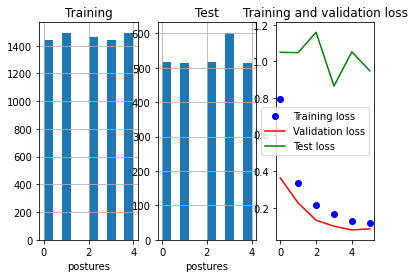

84/84 - 0s - loss: 0.9488 - accuracy: 0.6991

Test accuracy: 0.699061930179596


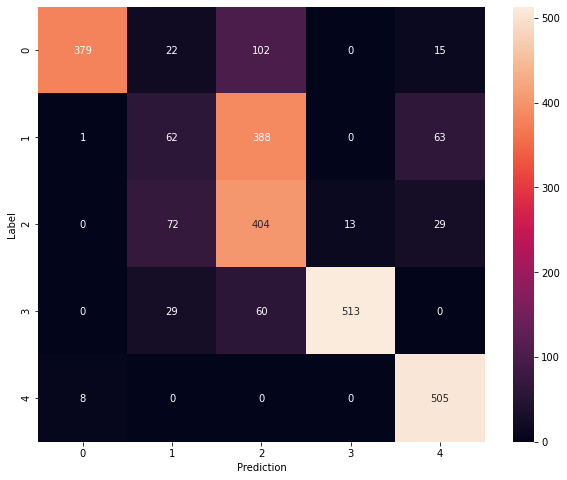

Model: "sequential_278"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_278 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 145)               1885      
_________________________________________________________________
dropout_278 (Dropout)        (None, 145)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 730       
Total params: 2,615
Trainable params: 2,615
Non-trainable params: 0
_________________________________________________________________
76 out of 100 runs
Epoch 1/30
225/225 [==============================] - 1s 4ms/step - loss: 1.1538 - accuracy: 0.5294 - val_loss: 0.8166 - val_accuracy: 0.6375

Epoch 00001: val_accuracy improved from -inf to 0.63754, saving model to training_76/c

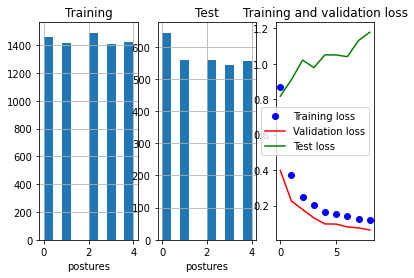

90/90 - 0s - loss: 1.1770 - accuracy: 0.7487

Test accuracy: 0.7486892938613892


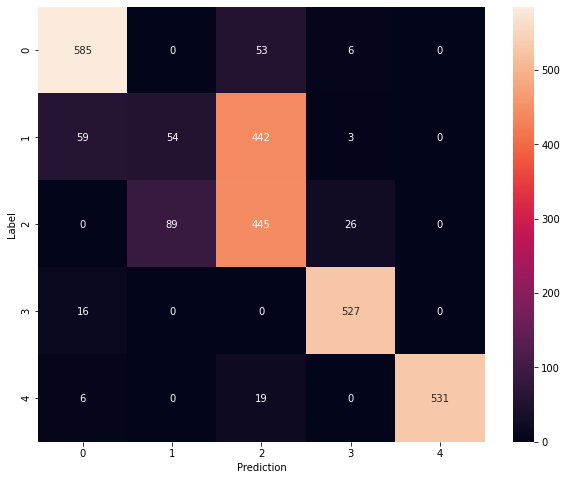

Model: "sequential_279"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_279 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 145)               1885      
_________________________________________________________________
dropout_279 (Dropout)        (None, 145)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 730       
Total params: 2,615
Trainable params: 2,615
Non-trainable params: 0
_________________________________________________________________
77 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1299 - accuracy: 0.5695 - val_loss: 0.8891 - val_accuracy: 0.6185

Epoch 00001: val_accuracy improved from -inf to 0.61855, saving model to training_77/c

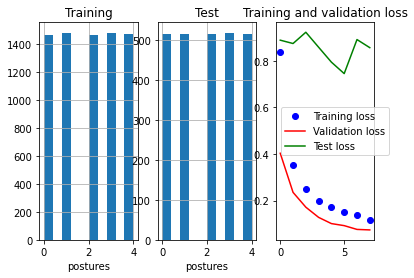

81/81 - 0s - loss: 0.8569 - accuracy: 0.7800

Test accuracy: 0.7799767255783081


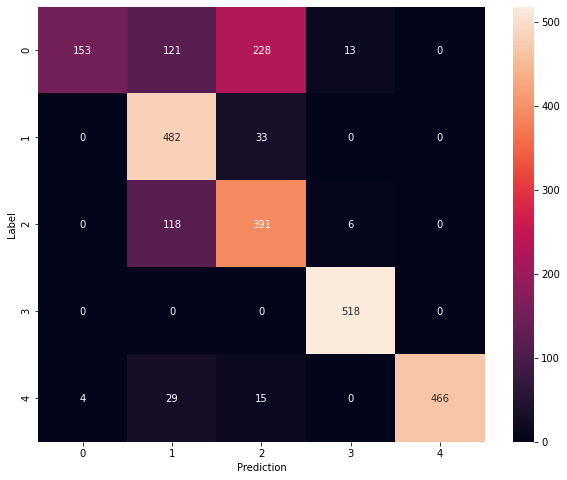

Model: "sequential_280"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_280 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 145)               1885      
_________________________________________________________________
dropout_280 (Dropout)        (None, 145)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 730       
Total params: 2,615
Trainable params: 2,615
Non-trainable params: 0
_________________________________________________________________
78 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.0835 - accuracy: 0.5705 - val_loss: 1.2373 - val_accuracy: 0.5469

Epoch 00001: val_accuracy improved from -inf to 0.54694, saving model to training_78/c

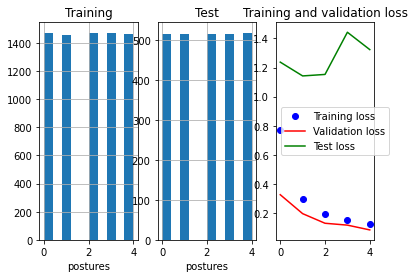

81/81 - 0s - loss: 1.3235 - accuracy: 0.5745

Test accuracy: 0.5744763612747192


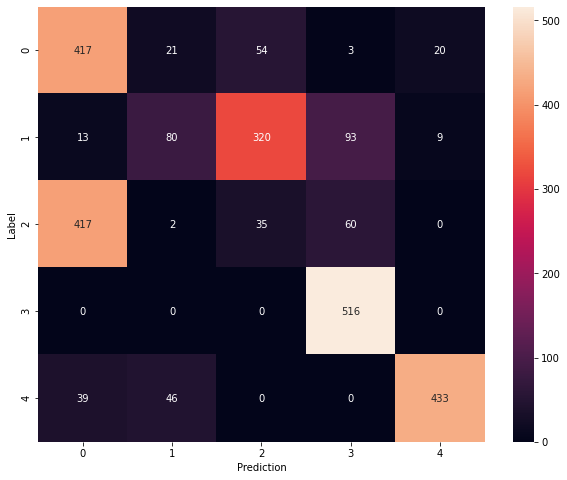

Model: "sequential_281"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_281 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 145)               1885      
_________________________________________________________________
dropout_281 (Dropout)        (None, 145)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 730       
Total params: 2,615
Trainable params: 2,615
Non-trainable params: 0
_________________________________________________________________
79 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1030 - accuracy: 0.5561 - val_loss: 1.0976 - val_accuracy: 0.6149

Epoch 00001: val_accuracy improved from -inf to 0.61494, saving model to training_79/c

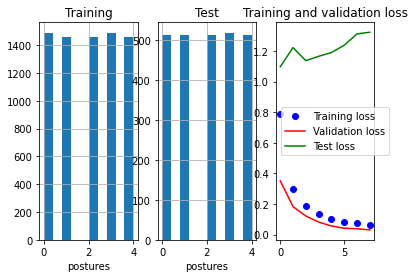

81/81 - 0s - loss: 1.3231 - accuracy: 0.7110

Test accuracy: 0.7110074162483215


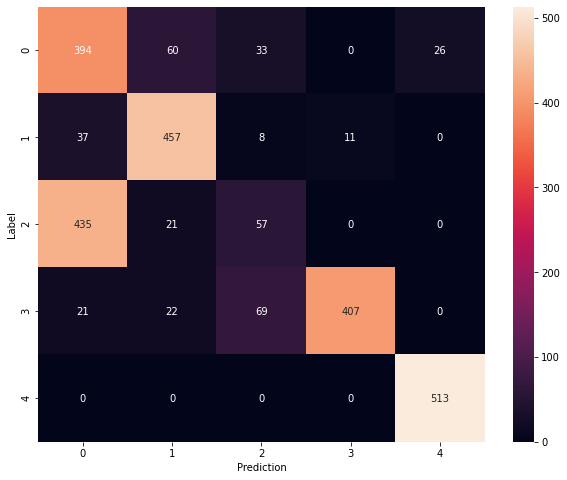

Model: "sequential_282"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_282 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 150)               1950      
_________________________________________________________________
dropout_282 (Dropout)        (None, 150)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 755       
Total params: 2,705
Trainable params: 2,705
Non-trainable params: 0
_________________________________________________________________
80 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1251 - accuracy: 0.5424 - val_loss: 1.5506 - val_accuracy: 0.4732

Epoch 00001: val_accuracy improved from -inf to 0.47317, saving model to training_80/c

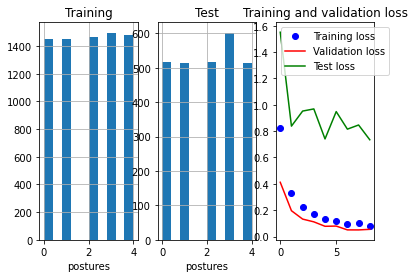

84/84 - 0s - loss: 0.7345 - accuracy: 0.7261

Test accuracy: 0.7260788083076477


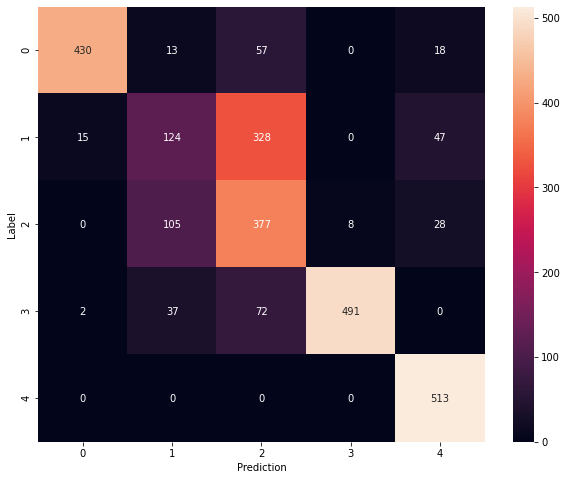

Model: "sequential_283"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_283 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 150)               1950      
_________________________________________________________________
dropout_283 (Dropout)        (None, 150)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 755       
Total params: 2,705
Trainable params: 2,705
Non-trainable params: 0
_________________________________________________________________
81 out of 100 runs
Epoch 1/30
225/225 [==============================] - 1s 4ms/step - loss: 1.1517 - accuracy: 0.5237 - val_loss: 0.9790 - val_accuracy: 0.6659

Epoch 00001: val_accuracy improved from -inf to 0.66585, saving model to training_81/c

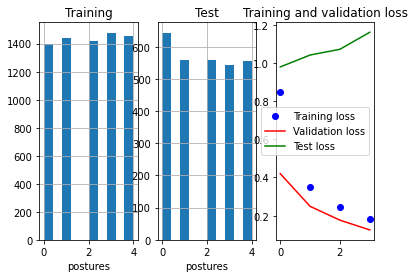

90/90 - 0s - loss: 1.1607 - accuracy: 0.7088

Test accuracy: 0.7088430523872375


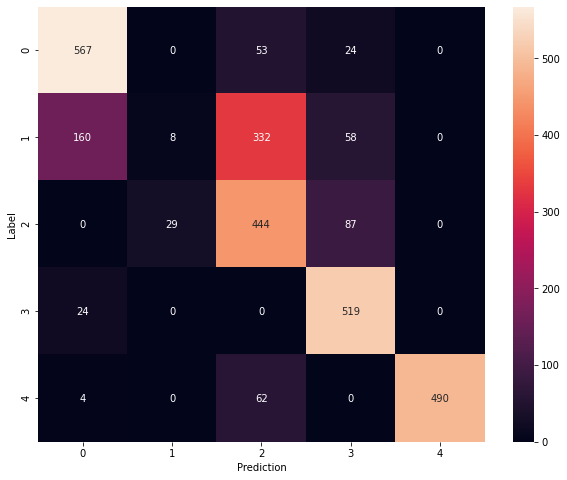

Model: "sequential_284"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_284 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 150)               1950      
_________________________________________________________________
dropout_284 (Dropout)        (None, 150)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 755       
Total params: 2,705
Trainable params: 2,705
Non-trainable params: 0
_________________________________________________________________
82 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1300 - accuracy: 0.5608 - val_loss: 1.0266 - val_accuracy: 0.6023

Epoch 00001: val_accuracy improved from -inf to 0.60225, saving model to training_82/c

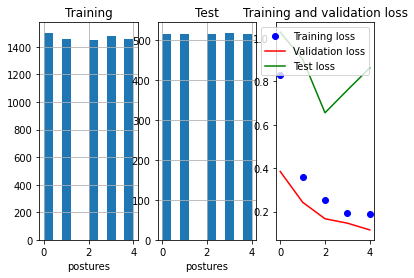

81/81 - 0s - loss: 0.8623 - accuracy: 0.7175

Test accuracy: 0.7175009846687317


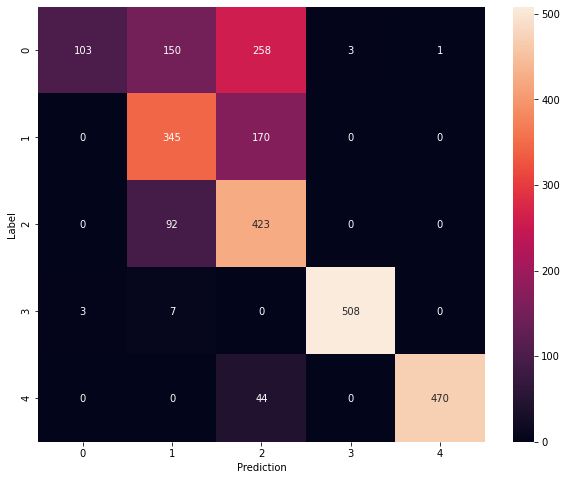

Model: "sequential_285"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_285 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 150)               1950      
_________________________________________________________________
dropout_285 (Dropout)        (None, 150)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 755       
Total params: 2,705
Trainable params: 2,705
Non-trainable params: 0
_________________________________________________________________
83 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.0891 - accuracy: 0.5632 - val_loss: 1.2281 - val_accuracy: 0.5543

Epoch 00001: val_accuracy improved from -inf to 0.55431, saving model to training_83/c

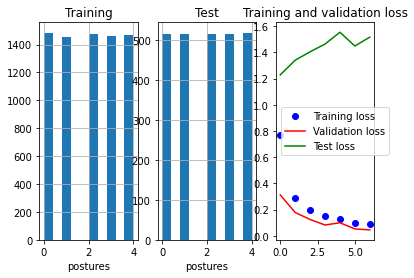

81/81 - 0s - loss: 1.5158 - accuracy: 0.6109

Test accuracy: 0.6109387278556824


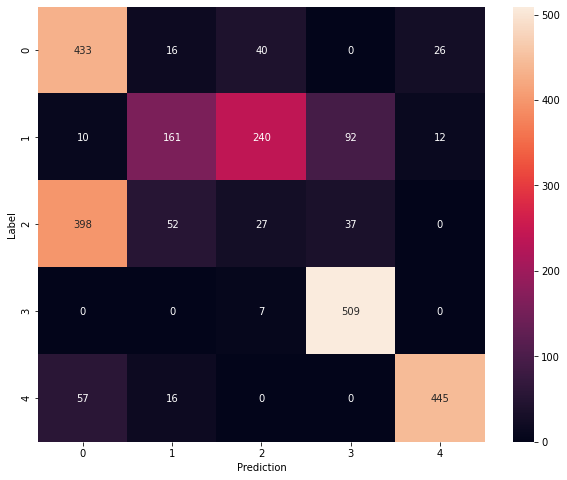

Model: "sequential_286"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_286 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 150)               1950      
_________________________________________________________________
dropout_286 (Dropout)        (None, 150)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 755       
Total params: 2,705
Trainable params: 2,705
Non-trainable params: 0
_________________________________________________________________
84 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.0764 - accuracy: 0.5726 - val_loss: 0.9658 - val_accuracy: 0.6818

Epoch 00001: val_accuracy improved from -inf to 0.68184, saving model to training_84/c

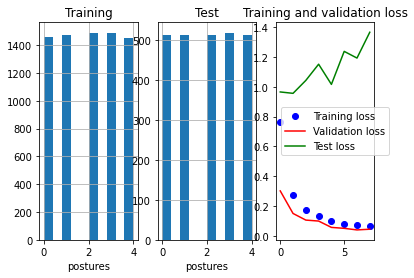

81/81 - 0s - loss: 1.3668 - accuracy: 0.7200

Test accuracy: 0.7199532985687256


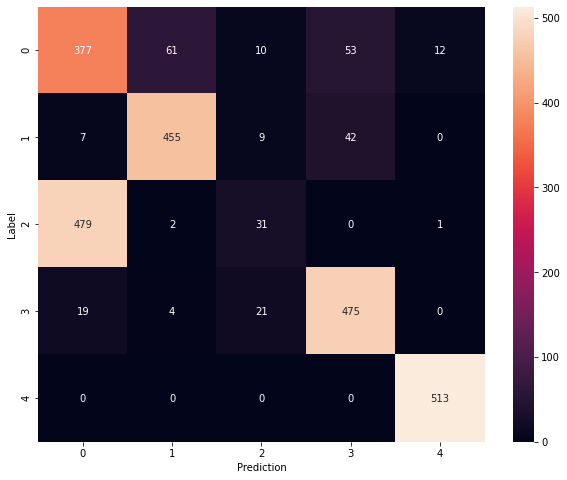

Model: "sequential_287"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_287 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 150)               1950      
_________________________________________________________________
dropout_287 (Dropout)        (None, 150)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 755       
Total params: 2,705
Trainable params: 2,705
Non-trainable params: 0
_________________________________________________________________
85 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1027 - accuracy: 0.5600 - val_loss: 1.2636 - val_accuracy: 0.5047

Epoch 00001: val_accuracy improved from -inf to 0.50469, saving model to training_85/c

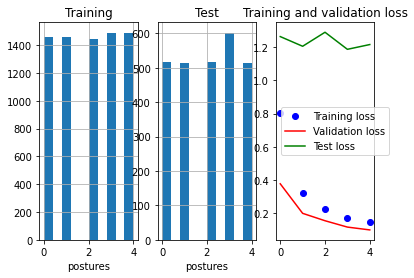

84/84 - 0s - loss: 1.2156 - accuracy: 0.6882

Test accuracy: 0.6881800889968872


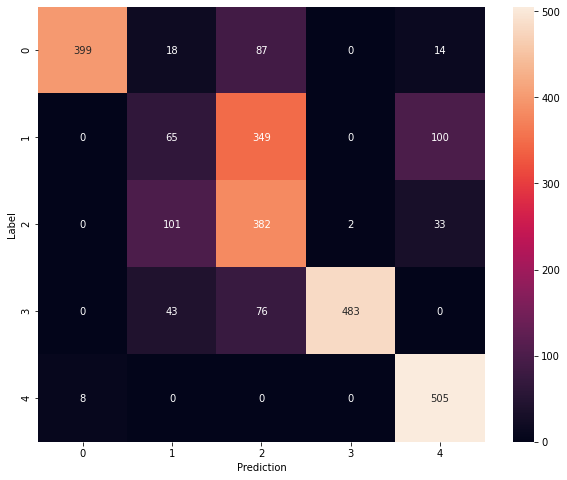

Model: "sequential_288"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_288 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 150)               1950      
_________________________________________________________________
dropout_288 (Dropout)        (None, 150)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 755       
Total params: 2,705
Trainable params: 2,705
Non-trainable params: 0
_________________________________________________________________
86 out of 100 runs
Epoch 1/30
225/225 [==============================] - 1s 4ms/step - loss: 1.1463 - accuracy: 0.5384 - val_loss: 0.9091 - val_accuracy: 0.6631

Epoch 00001: val_accuracy improved from -inf to 0.66305, saving model to training_86/c

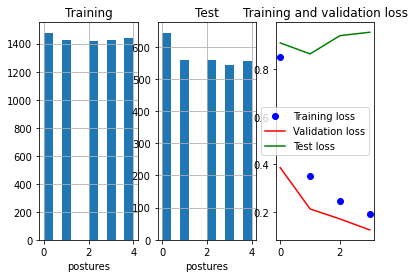

90/90 - 0s - loss: 0.9539 - accuracy: 0.7148

Test accuracy: 0.7147850394248962


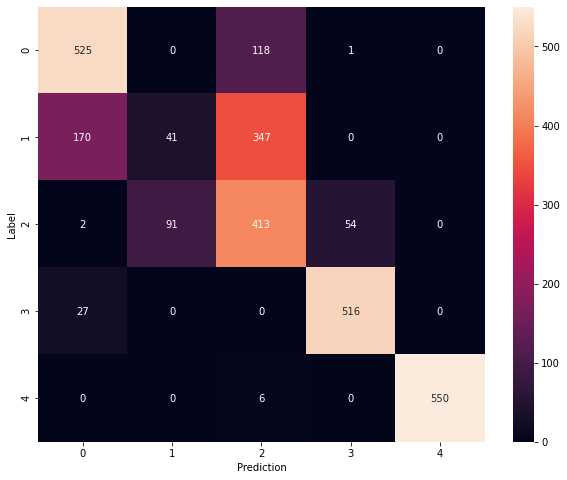

Model: "sequential_289"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_289 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 150)               1950      
_________________________________________________________________
dropout_289 (Dropout)        (None, 150)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 755       
Total params: 2,705
Trainable params: 2,705
Non-trainable params: 0
_________________________________________________________________
87 out of 100 runs
Epoch 1/30
230/230 [==============================] - 2s 5ms/step - loss: 1.1266 - accuracy: 0.5539 - val_loss: 0.9063 - val_accuracy: 0.5898

Epoch 00001: val_accuracy improved from -inf to 0.58983, saving model to training_87/c

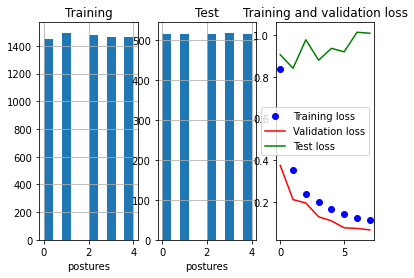

81/81 - 0s - loss: 1.0095 - accuracy: 0.7528

Test accuracy: 0.7528133392333984


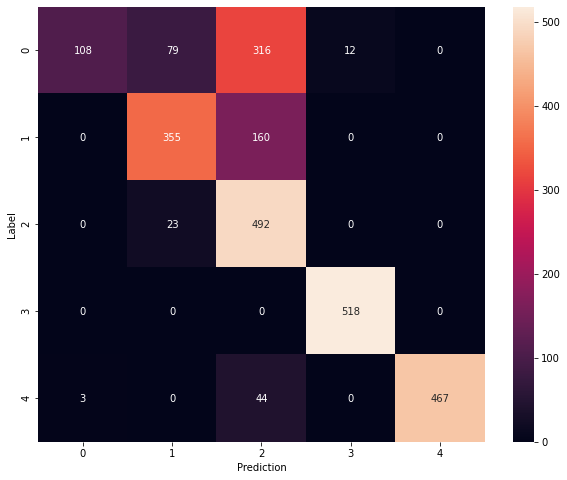

Model: "sequential_290"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_290 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 150)               1950      
_________________________________________________________________
dropout_290 (Dropout)        (None, 150)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 755       
Total params: 2,705
Trainable params: 2,705
Non-trainable params: 0
_________________________________________________________________
88 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.0990 - accuracy: 0.5576 - val_loss: 1.3683 - val_accuracy: 0.5163

Epoch 00001: val_accuracy improved from -inf to 0.51629, saving model to training_88/c

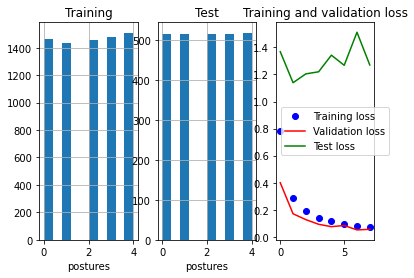

81/81 - 0s - loss: 1.2702 - accuracy: 0.6117

Test accuracy: 0.6117144823074341


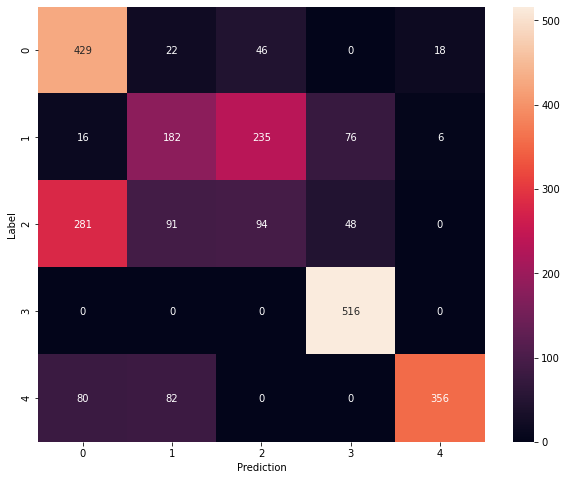

Model: "sequential_291"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_291 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 150)               1950      
_________________________________________________________________
dropout_291 (Dropout)        (None, 150)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 755       
Total params: 2,705
Trainable params: 2,705
Non-trainable params: 0
_________________________________________________________________
89 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1327 - accuracy: 0.5415 - val_loss: 1.0553 - val_accuracy: 0.6305

Epoch 00001: val_accuracy improved from -inf to 0.63049, saving model to training_89/c

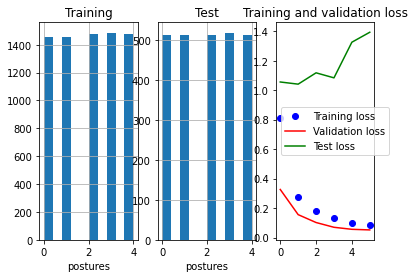

81/81 - 0s - loss: 1.3927 - accuracy: 0.6589

Test accuracy: 0.6588875651359558


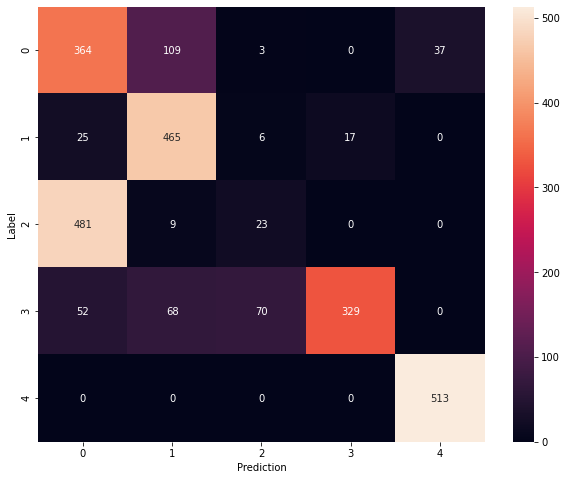

Model: "sequential_292"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_292 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 155)               2015      
_________________________________________________________________
dropout_292 (Dropout)        (None, 155)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 780       
Total params: 2,795
Trainable params: 2,795
Non-trainable params: 0
_________________________________________________________________
90 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.0781 - accuracy: 0.5698 - val_loss: 1.6273 - val_accuracy: 0.5122

Epoch 00001: val_accuracy improved from -inf to 0.51220, saving model to training_90/c

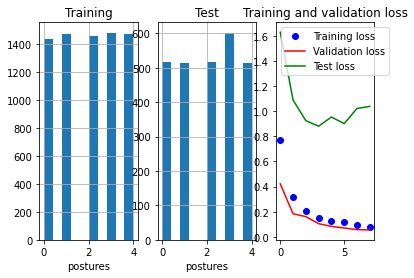

84/84 - 0s - loss: 1.0375 - accuracy: 0.7366

Test accuracy: 0.7365853786468506


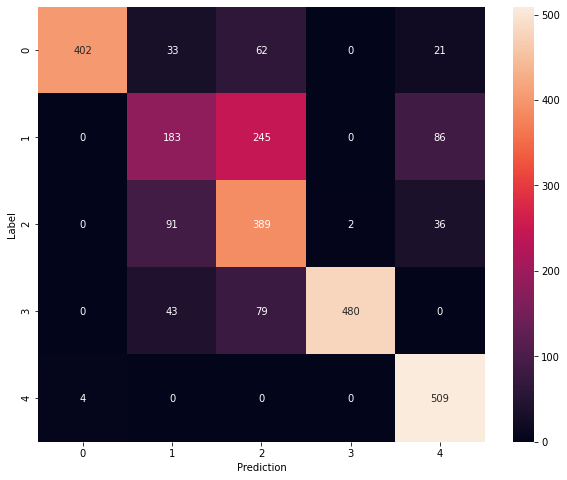

Model: "sequential_293"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_293 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 155)               2015      
_________________________________________________________________
dropout_293 (Dropout)        (None, 155)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 780       
Total params: 2,795
Trainable params: 2,795
Non-trainable params: 0
_________________________________________________________________
91 out of 100 runs
Epoch 1/30
225/225 [==============================] - 1s 4ms/step - loss: 1.1340 - accuracy: 0.5434 - val_loss: 0.9610 - val_accuracy: 0.6131

Epoch 00001: val_accuracy improved from -inf to 0.61307, saving model to training_91/c

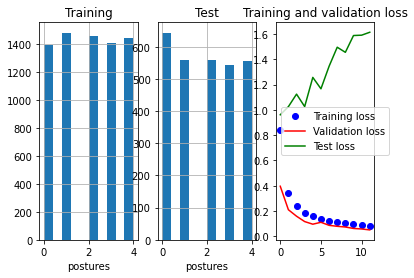

90/90 - 0s - loss: 1.6143 - accuracy: 0.7648

Test accuracy: 0.764767587184906


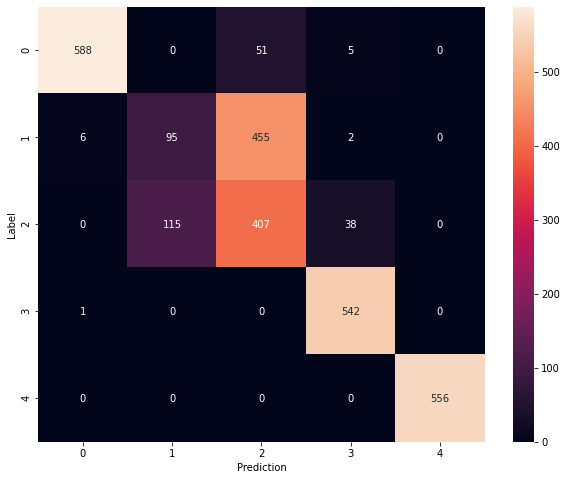

Model: "sequential_294"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_294 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 155)               2015      
_________________________________________________________________
dropout_294 (Dropout)        (None, 155)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 780       
Total params: 2,795
Trainable params: 2,795
Non-trainable params: 0
_________________________________________________________________
92 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1269 - accuracy: 0.5591 - val_loss: 1.0061 - val_accuracy: 0.6542

Epoch 00001: val_accuracy improved from -inf to 0.65425, saving model to training_92/c

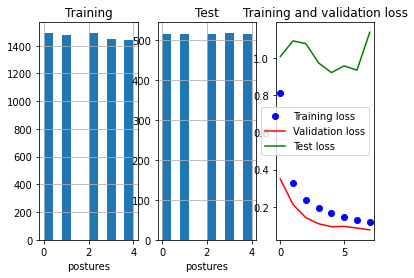

81/81 - 0s - loss: 1.1366 - accuracy: 0.7652

Test accuracy: 0.7652308940887451


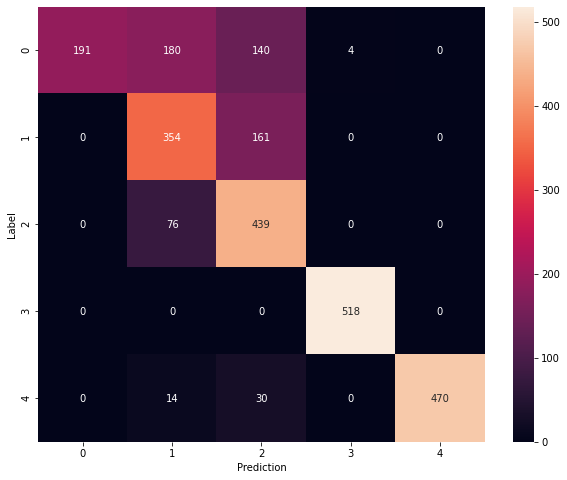

Model: "sequential_295"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_295 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 155)               2015      
_________________________________________________________________
dropout_295 (Dropout)        (None, 155)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 780       
Total params: 2,795
Trainable params: 2,795
Non-trainable params: 0
_________________________________________________________________
93 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.0828 - accuracy: 0.5704 - val_loss: 1.3224 - val_accuracy: 0.5330

Epoch 00001: val_accuracy improved from -inf to 0.53297, saving model to training_93/c

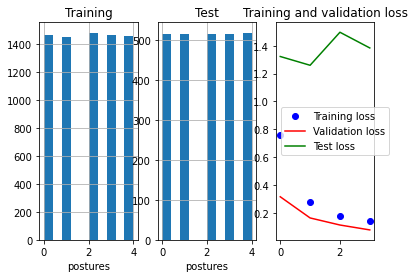

81/81 - 0s - loss: 1.3838 - accuracy: 0.5721

Test accuracy: 0.5721489787101746


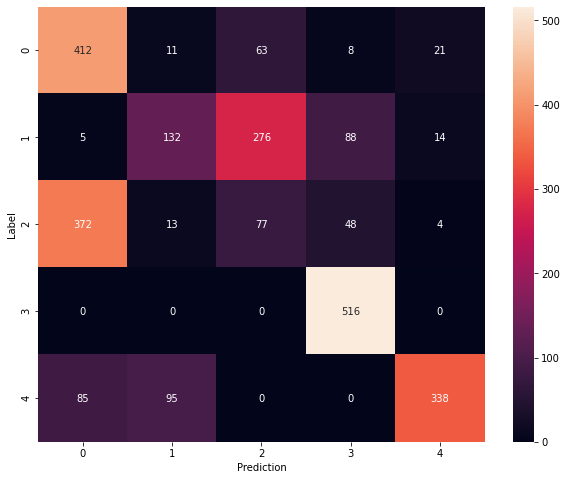

Model: "sequential_296"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_296 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 155)               2015      
_________________________________________________________________
dropout_296 (Dropout)        (None, 155)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 780       
Total params: 2,795
Trainable params: 2,795
Non-trainable params: 0
_________________________________________________________________
94 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1064 - accuracy: 0.5620 - val_loss: 1.2658 - val_accuracy: 0.6009

Epoch 00001: val_accuracy improved from -inf to 0.60093, saving model to training_94/c

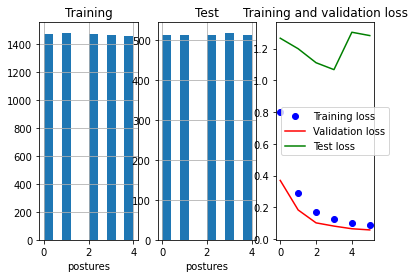

81/81 - 0s - loss: 1.2825 - accuracy: 0.7172

Test accuracy: 0.7172306776046753


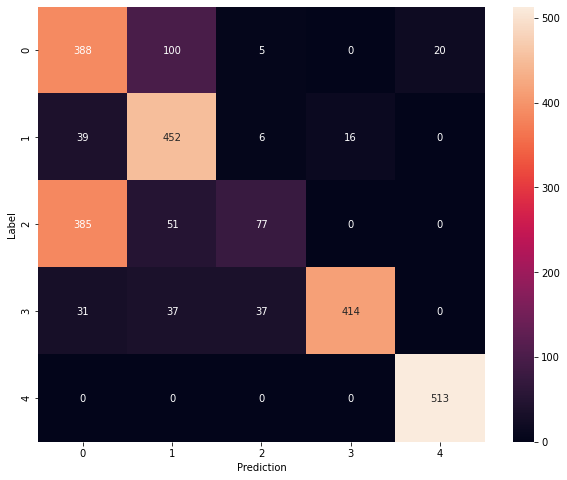

Model: "sequential_297"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_297 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 155)               2015      
_________________________________________________________________
dropout_297 (Dropout)        (None, 155)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 780       
Total params: 2,795
Trainable params: 2,795
Non-trainable params: 0
_________________________________________________________________
95 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1107 - accuracy: 0.5555 - val_loss: 1.3355 - val_accuracy: 0.5107

Epoch 00001: val_accuracy improved from -inf to 0.51069, saving model to training_95/c

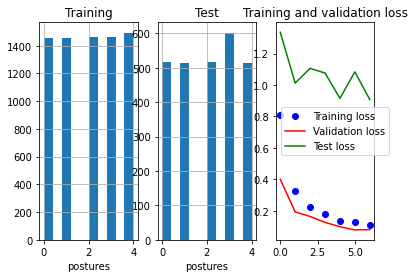

84/84 - 0s - loss: 0.9074 - accuracy: 0.7118

Test accuracy: 0.7118198871612549


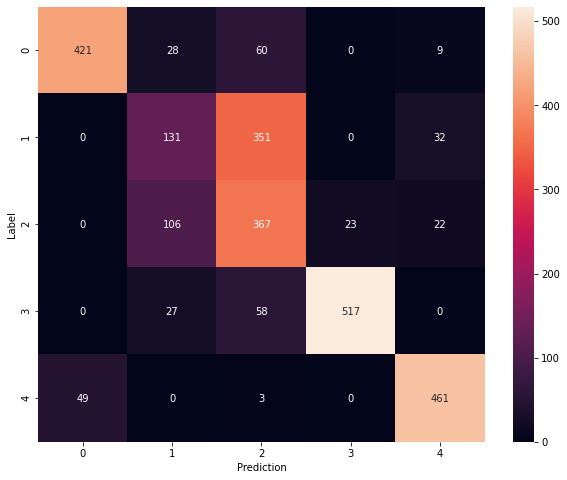

Model: "sequential_298"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_298 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 155)               2015      
_________________________________________________________________
dropout_298 (Dropout)        (None, 155)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 780       
Total params: 2,795
Trainable params: 2,795
Non-trainable params: 0
_________________________________________________________________
96 out of 100 runs
Epoch 1/30
225/225 [==============================] - 1s 4ms/step - loss: 1.1106 - accuracy: 0.5570 - val_loss: 0.9040 - val_accuracy: 0.6554

Epoch 00001: val_accuracy improved from -inf to 0.65537, saving model to training_96/c

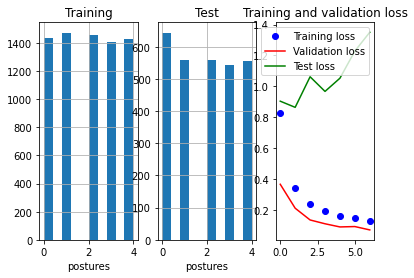

90/90 - 0s - loss: 1.3506 - accuracy: 0.6788

Test accuracy: 0.678783655166626


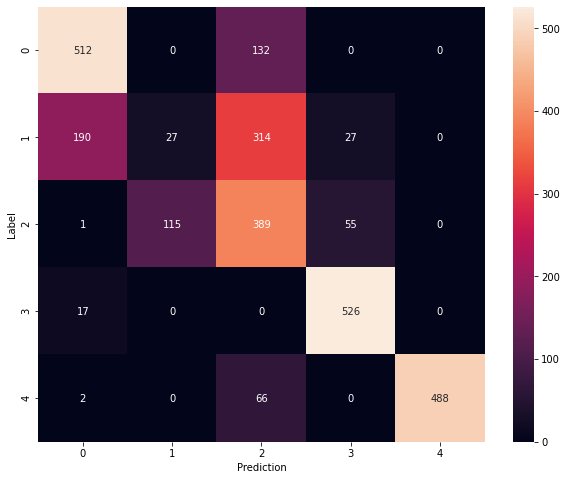

Model: "sequential_299"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_299 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 155)               2015      
_________________________________________________________________
dropout_299 (Dropout)        (None, 155)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 780       
Total params: 2,795
Trainable params: 2,795
Non-trainable params: 0
_________________________________________________________________
97 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.1322 - accuracy: 0.5472 - val_loss: 0.9345 - val_accuracy: 0.6919

Epoch 00001: val_accuracy improved from -inf to 0.69189, saving model to training_97/c

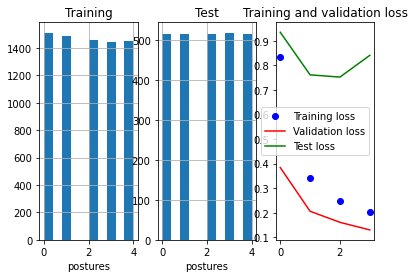

81/81 - 0s - loss: 0.8405 - accuracy: 0.7097

Test accuracy: 0.7097399830818176


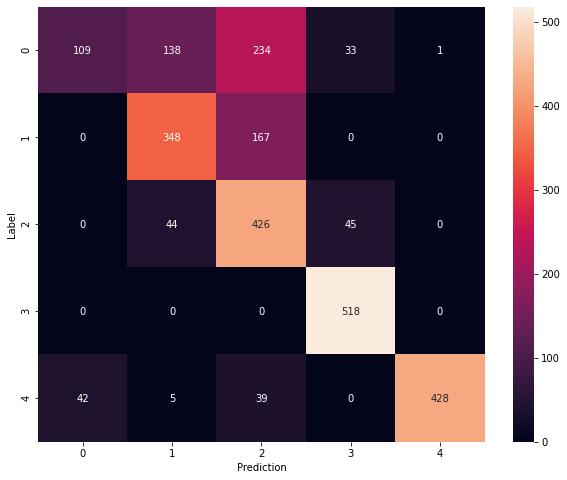

Model: "sequential_300"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_300 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 155)               2015      
_________________________________________________________________
dropout_300 (Dropout)        (None, 155)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 780       
Total params: 2,795
Trainable params: 2,795
Non-trainable params: 0
_________________________________________________________________
98 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.0684 - accuracy: 0.5646 - val_loss: 1.3014 - val_accuracy: 0.5248

Epoch 00001: val_accuracy improved from -inf to 0.52483, saving model to training_98/c

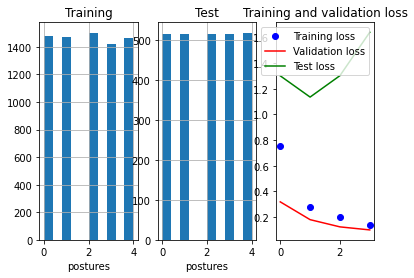

81/81 - 0s - loss: 1.6414 - accuracy: 0.5551

Test accuracy: 0.5550814867019653


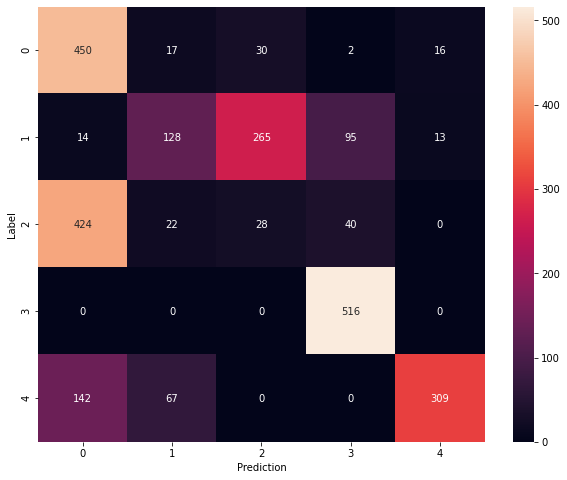

Model: "sequential_301"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_301 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 155)               2015      
_________________________________________________________________
dropout_301 (Dropout)        (None, 155)               0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 780       
Total params: 2,795
Trainable params: 2,795
Non-trainable params: 0
_________________________________________________________________
99 out of 100 runs
Epoch 1/30
230/230 [==============================] - 1s 4ms/step - loss: 1.0889 - accuracy: 0.5536 - val_loss: 0.8776 - val_accuracy: 0.6464

Epoch 00001: val_accuracy improved from -inf to 0.64644, saving model to training_99/c

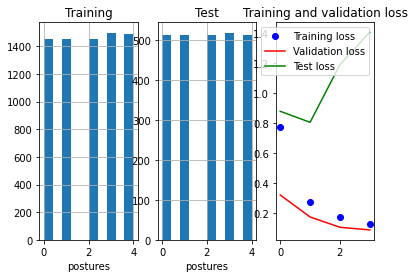

81/81 - 0s - loss: 1.4057 - accuracy: 0.6324

Test accuracy: 0.6324387192726135


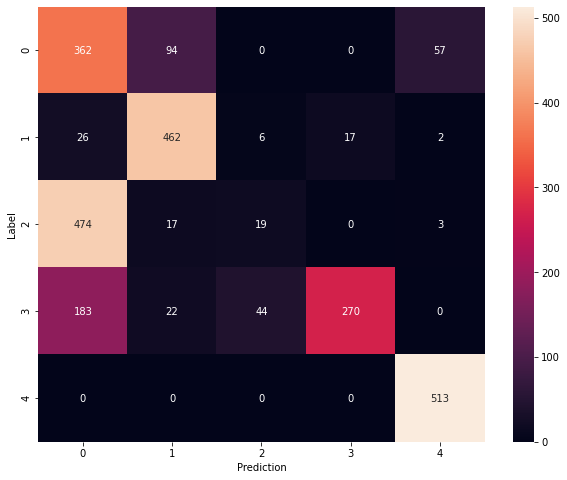

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
#########################################################################################################################################################################
#   This block of code is for trying different model configurations and seeing what works best
#########################################################################################################################################################################

#Affects the range of layers that the models will have and how much times we want to test that setup
i_range = 10
j_range = 1
k_range = 10 #use multiple of total datasets

hidden_layer_1 = 110
hidden_layer_2 = 30
hidden_layer_1_interval = 5
hidden_layer_2_interval = 5

starting_num_epochs = 30

dropout_percent = 0.2
callback_patience=2
decay_rate = 0.90
decay_steps = 200

saved_metric_name = 'Model_CONFIG_05'
#########################################################################################################################################################################

curr_run = 0
total_run = i_range*j_range*k_range 

#Test different configuration of models
test_history = pd.DataFrame(columns=['Accuracy','Layer 1','Layer 2','Dropout %','Average of','Patience','IN Learning Rate','decay_rate','decay_steps'])
for i in range(0,i_range):
  for j in range(0,j_range):
    average_accuracy = 0;
    for k in range(0,k_range):
      
      get_data(curr_run%5)
      plt.subplot(1,3,1)
      y_train.hist() #displays the histogram based on posture
      plt.title("Training")
      plt.xlabel('postures')
      plt.subplot(1,3,2)
      test_pop.hist()
      plt.title("Test")
      plt.xlabel('postures')

      initial_learning_rate = (hidden_layer_1+i*hidden_layer_1_interval)/10000
      #Creates the model structure and chooses the activation function for each layer
      model = tf.keras.Sequential([                      
          tf.keras.layers.Flatten(input_shape=(12,1)),
          tf.keras.layers.Dense(hidden_layer_1+i*hidden_layer_1_interval, activation='relu', name= "Layer_1"),  #hidden layers are generally: relu, sigmoid, tanh (Usually constant for all hidden layers)
          tf.keras.layers.Dropout(dropout_percent), #dropouts only occur during training
          # tf.keras.layers.Dense(hidden_layer_2+j*hidden_layer_2_interval, activation='relu', name= "Layer_2"),  
          # tf.keras.layers.Dropout(dropout_percent),
          tf.keras.layers.Dense(5, activation='linear', name= "Predicted_Posture"), #output layers are generally: linear, sigmoid, softmax
      ])
      model.summary()

      #Stops the model training early to prevent overfitting
      callbacks = [
      tf.keras.callbacks.EarlyStopping(# Stop training when `val_loss` is no longer improving
          monitor="val_accuracy",
          # min_delta=callback_delta,
          mode='auto',
          patience=callback_patience,# "no longer improving" being further defined as "for at least x epochs"
          verbose=1,
        )
      ] 

      #Addes the x_val dataset to be tested 
      val_test = AdditionalValidationSets([(x_val, y_val, 'val2')])

      #Saves the models when the accuracy is highest based on the test values
      checkpoint_path = "training_"+str(curr_run)+"/cp.ckpt"
      checkpoint_dir = os.path.dirname(checkpoint_path)
      cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor="val_accuracy",mode= "auto",save_best_only=True,save_weights_only=True,verbose=1)

      #Assign type of: optimizer, loss, and metric
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)
      opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
      model.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

      #Print out which loop we are undergoing
      print(str(curr_run)+" out of "+str(total_run) + " runs")

      #Train the model with the training data and save the stats in history
      history = model.fit(x_train,y_train,epochs=starting_num_epochs,callbacks = [val_test,callbacks,cp_callback],validation_data=(test, test_pop),shuffle = True)

      #Plots the training vs validation loss
      loss = history.history['loss']
      test_loss = history.history['val_loss']
      val_loss = val_test.history['val2_loss']
      epochs = history.epoch
      plt.subplot(1,3,3)
      plt.plot(epochs, loss, 'bo', label='Training loss')
      plt.plot(epochs, val_loss, 'r', label='Validation loss')
      plt.plot(epochs, test_loss, 'g', label='Test loss')
      plt.title('Training and validation loss')
      plt.legend()
      plt.show()

      #Test the model with unseen data and record the settings
      test_loss, test_acc = model.evaluate(test,  test_pop, verbose=2)
      print('\nTest accuracy:', test_acc)

      #create a confusion matrix to see model performance
      predictions = model.predict(test)
      predictions = np.argmax(predictions,axis = 1)
      confusion_mtx = tf.math.confusion_matrix(
          test_pop, predictions, 5, weights=None, dtype=tf.dtypes.int32,
          name='PCD_Confusion_Matrix'
      )
      plt.figure(figsize=(10, 8))
      sns.heatmap(confusion_mtx,annot=True, fmt='g')
      plt.xlabel('Prediction')
      plt.ylabel('Label')
      plt.show()
      average_accuracy = average_accuracy + test_acc
      curr_run = curr_run + 1

    #Records the test results for specific model configuration
    average_accuracy = average_accuracy/k_range
    new_row = {'Accuracy':average_accuracy,'Layer 1':hidden_layer_1+i*hidden_layer_1_interval,'Layer 2':hidden_layer_2+j*hidden_layer_2_interval,'Dropout %':dropout_percent,
               'Average of':k_range,'Patience':callback_patience,'IN Learning Rate':initial_learning_rate,'decay_rate':decay_rate,'decay_steps':decay_steps}
    test_history = test_history.append(new_row, ignore_index=True)
test_history.to_csv(saved_metric_name+".csv",index=False)
from google.colab import files
files.download(saved_metric_name+".csv")
#########################################################################################################################################################################

In [1]:
# Loads the weights
model.load_weights("training_1/cp.ckpt")

# Re-evaluate the model
loss, acc = model.evaluate(test, test_pop, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

NameError: ignored

In [140]:
 test_history

Accuracy  Layer 1  Layer 2  ...  IN Learning Rate  decay_rate  decay_steps
0  0.383865     30.0     15.0  ...             0.003         0.9        200.0
1  0.569381     30.0     20.0  ...             0.003         0.9        200.0

[2 rows x 9 columns]

In [77]:
def softmax(x):
    ex = np.exp(x)
    sum_ex = np.sum( np.exp(x))
    return ex/sum_ex

In [87]:
predictions = model.predict(test[1:2])
predictions = softmax(predictions)
predictions = predictions*100
np.round(predictions,3)

array([[3.5357e+01, 5.7385e+01, 7.0240e+00, 6.0000e-03, 2.2800e-01]],
      dtype=float32)

In [76]:
from google.colab import files
test_history.to_csv('Dropout_01_5.csv',index=False)
files.download("Dropout_01_5.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **CONVERT**

In [99]:
#########################################################################################################################################################################
#   Optimize the model for size and convert to tflite model
#########################################################################################################################################################################

#Covert the model to a tflite model & optimize to reduce the size
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

#########################################################################################################################################################################

INFO:tensorflow:Assets written to: /tmp/tmp7zmu5mu3/assets


7792

In [100]:
#########################################################################################################################################################################
#   Function to convert tflite file to C header file
#########################################################################################################################################################################

# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

#########################################################################################################################################################################

In [101]:
#########################################################################################################################################################################
#   Convert to c-header file via function
#########################################################################################################################################################################

# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))

#########################################################################################################################################################################